<a href="https://colab.research.google.com/github/AidenJiang01/WebScraping_TextMining/blob/main/GAA_Patent_Inventor_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
getwd()

# upload GAA_patents_clean.csv to working directory

[1] "/content"

In [ ]:
df <- read.csv("GAA_patents_clean.csv")

# Convert the integer date column to character
df$filing_date <- as.character(df$filing_date)

# Extract the first four characters to get the year
df$filing_year <- substr(df$filing_date, 1, 4)

# Convert the year column to integer
df$filing_year <- as.integer(df$filing_year)

In [ ]:
summary(df$filing_year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1977    2017    2018    2018    2020    2023 

In [ ]:
library(tidyverse)
if (!requireNamespace("igraph", quietly = TRUE)) {
  install.packages("igraph")
}
library(igraph)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package

In [ ]:
window_patent_inventor_edgelist <- function(window_width, start_year){
    # filing year window
    window = df[df$filing_year >= start_year & df$filing_year < start_year + window_width,
        c("id","inventor")]

    # Convert the inventor column to a list
    window <- window %>% mutate(inventor = str_remove_all(inventor, "\\[|\\]|'")
                      %>% strsplit(", ")
                      %>% lapply(trimws))

    # Unnest the inventor column to create the desired format
    window_long <- window %>% unnest(inventor)

    return(window_long)
}

In [ ]:
# Create a bipartite graph
bipartite_graph <- function(window_long){
    # Assign types: patents (type=TRUE), inventors (type=FALSE)
    patents <- unique(window_long$id)
    inventors <- unique(window_long$inventor)

    # Create a bipartite edge list
    edge_list <- data.frame(
      from = match(window_long$id, patents),
      to = match(window_long$inventor, inventors) + length(patents)
      )

    # Create a bipartite graph from the edge list
    g <- graph_from_data_frame(edge_list, directed = FALSE)
    V(g)$type <- bipartite_mapping(g)$type

    # Assign vertex names
    V(g)$name <- c(patents, inventors)

    return(g)
}

In [ ]:
plotting_key_inventors <- function(g, degree_threshold){
  options(repr.plot.width = 15, repr.plot.height = 15)

  # Calculate the degree of each node
  node_degrees <- degree(g)

  # Determine which inventor nodes have degree > degree_threshold
  inventor_nodes <- V(g)$type
  inventor_node_degrees <- node_degrees[inventor_nodes]
  label_nodes <- inventor_node_degrees > degree_threshold

  # Create a label vector with NA for nodes that should not be labeled
  vertex_labels <- rep(NA, vcount(g))
  vertex_labels[inventor_nodes] <- ifelse(label_nodes, V(g)$name[inventor_nodes], NA)

  # Plot the bipartite graph
  plot(g, vertex.label = vertex_labels,
    vertex.color = V(g)$type,
    vertex.size = 1,
    vertex.shape = ifelse(V(g)$type, "square", "circle"),
    layout = layout_with_fr(g),
    edge.color = "gray",
    main = paste("year window:", start_year, "-", start_year + window_width - 1))
}


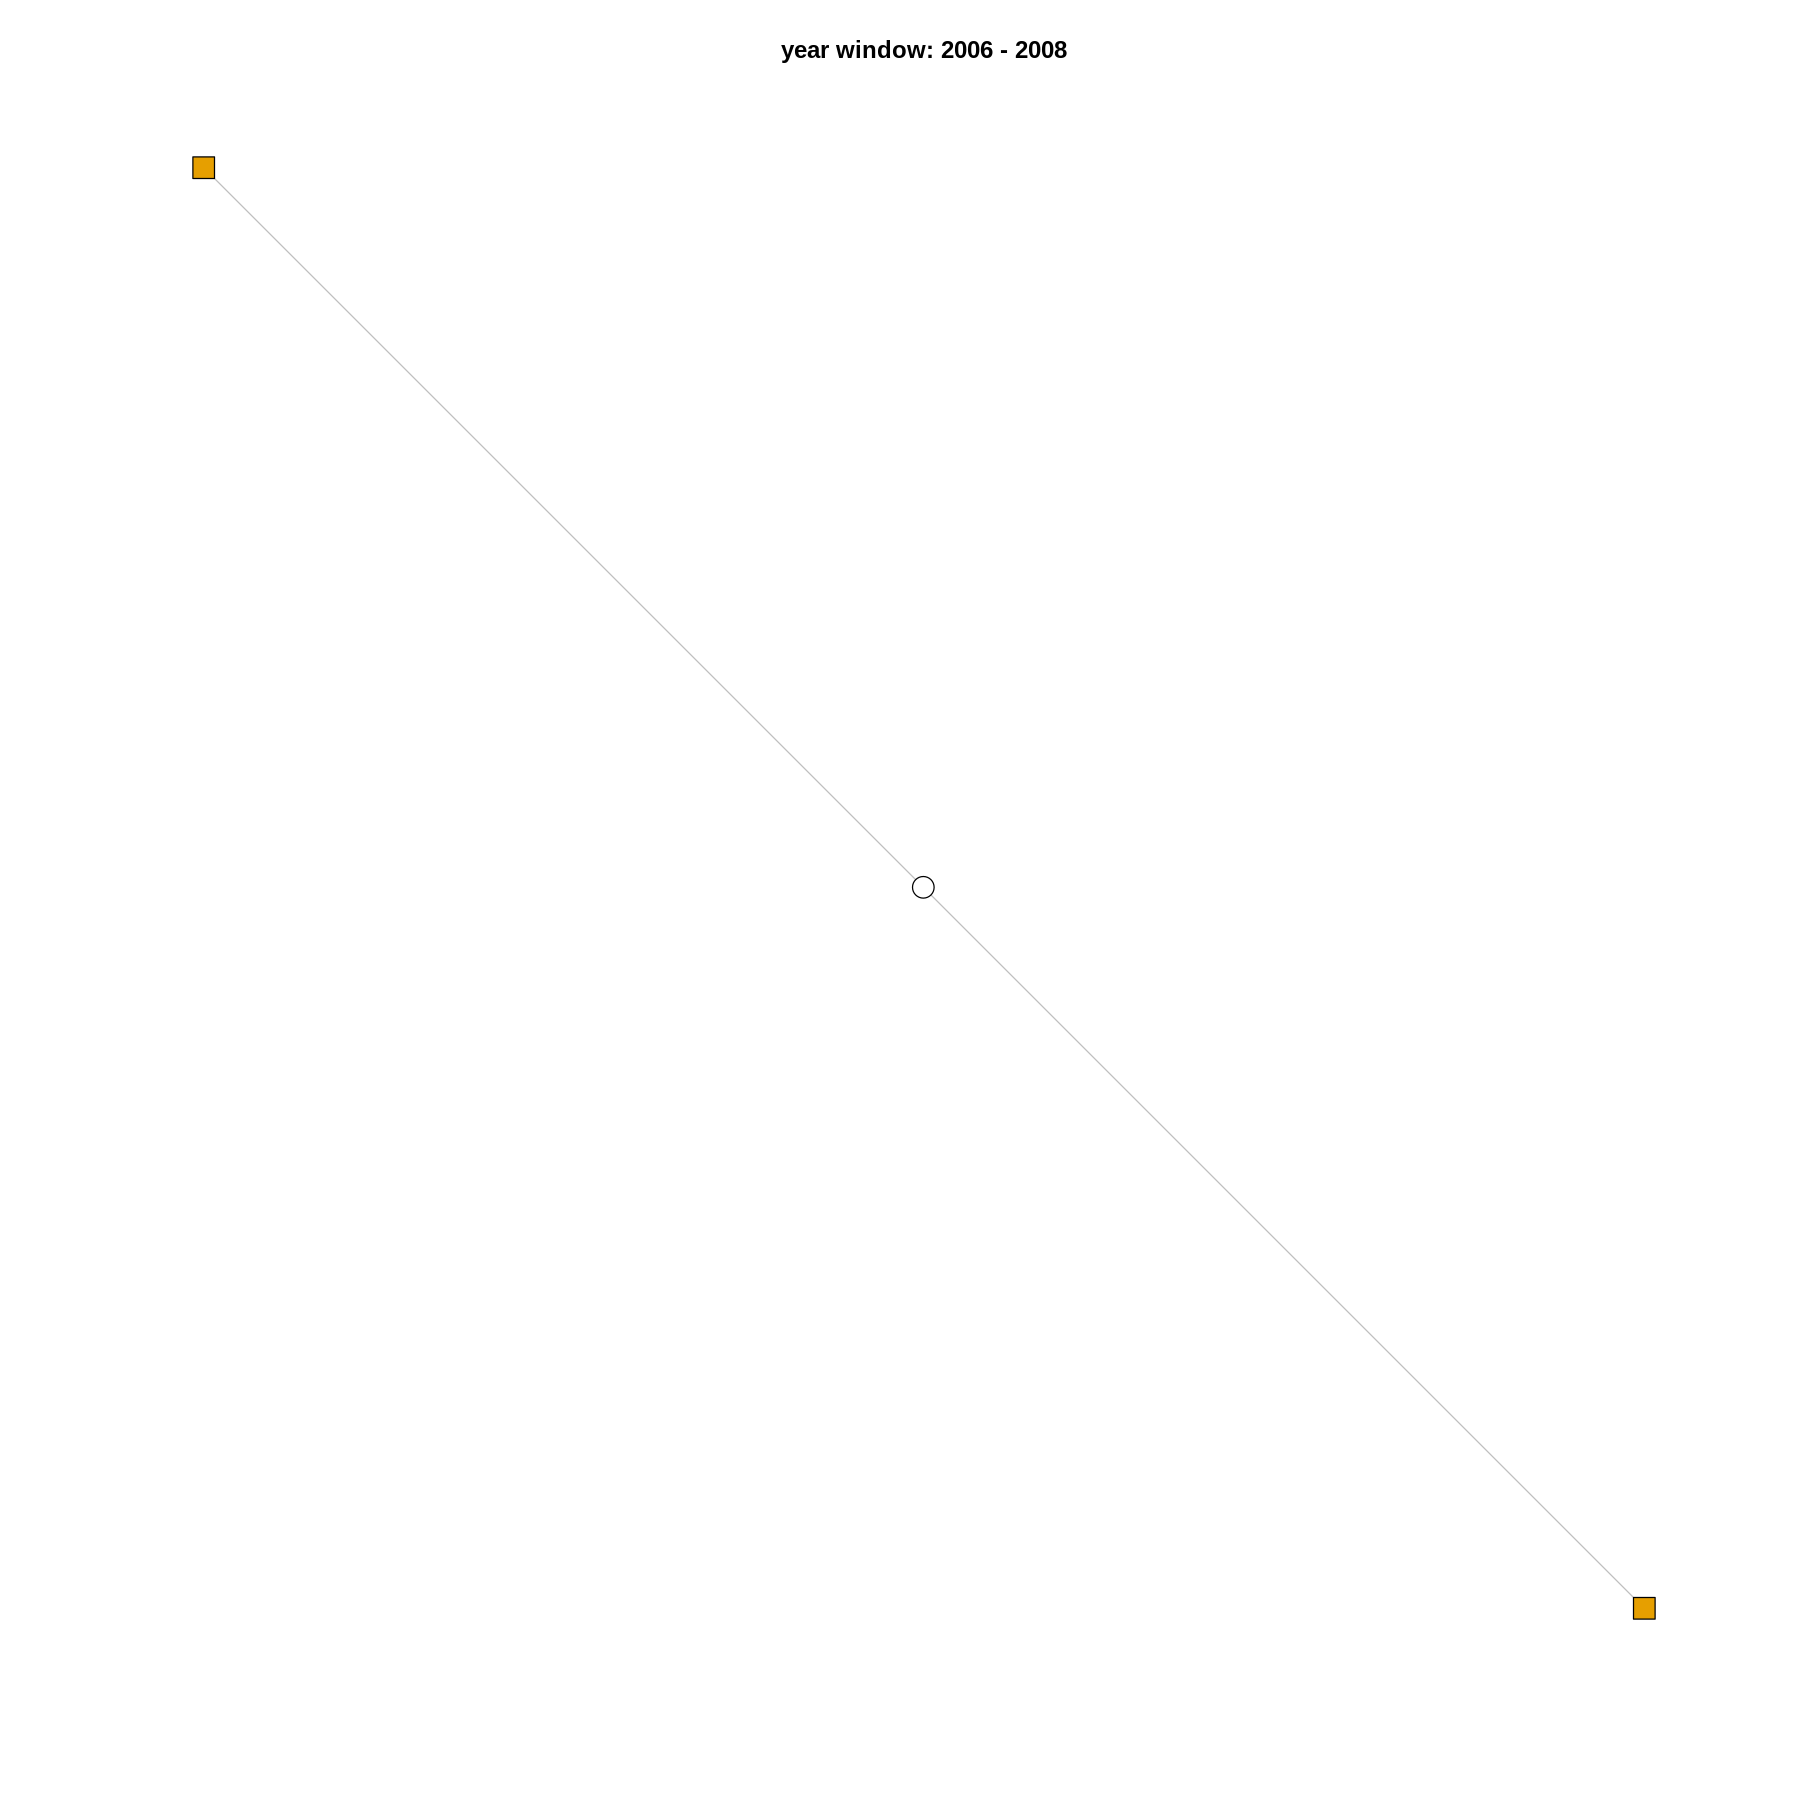

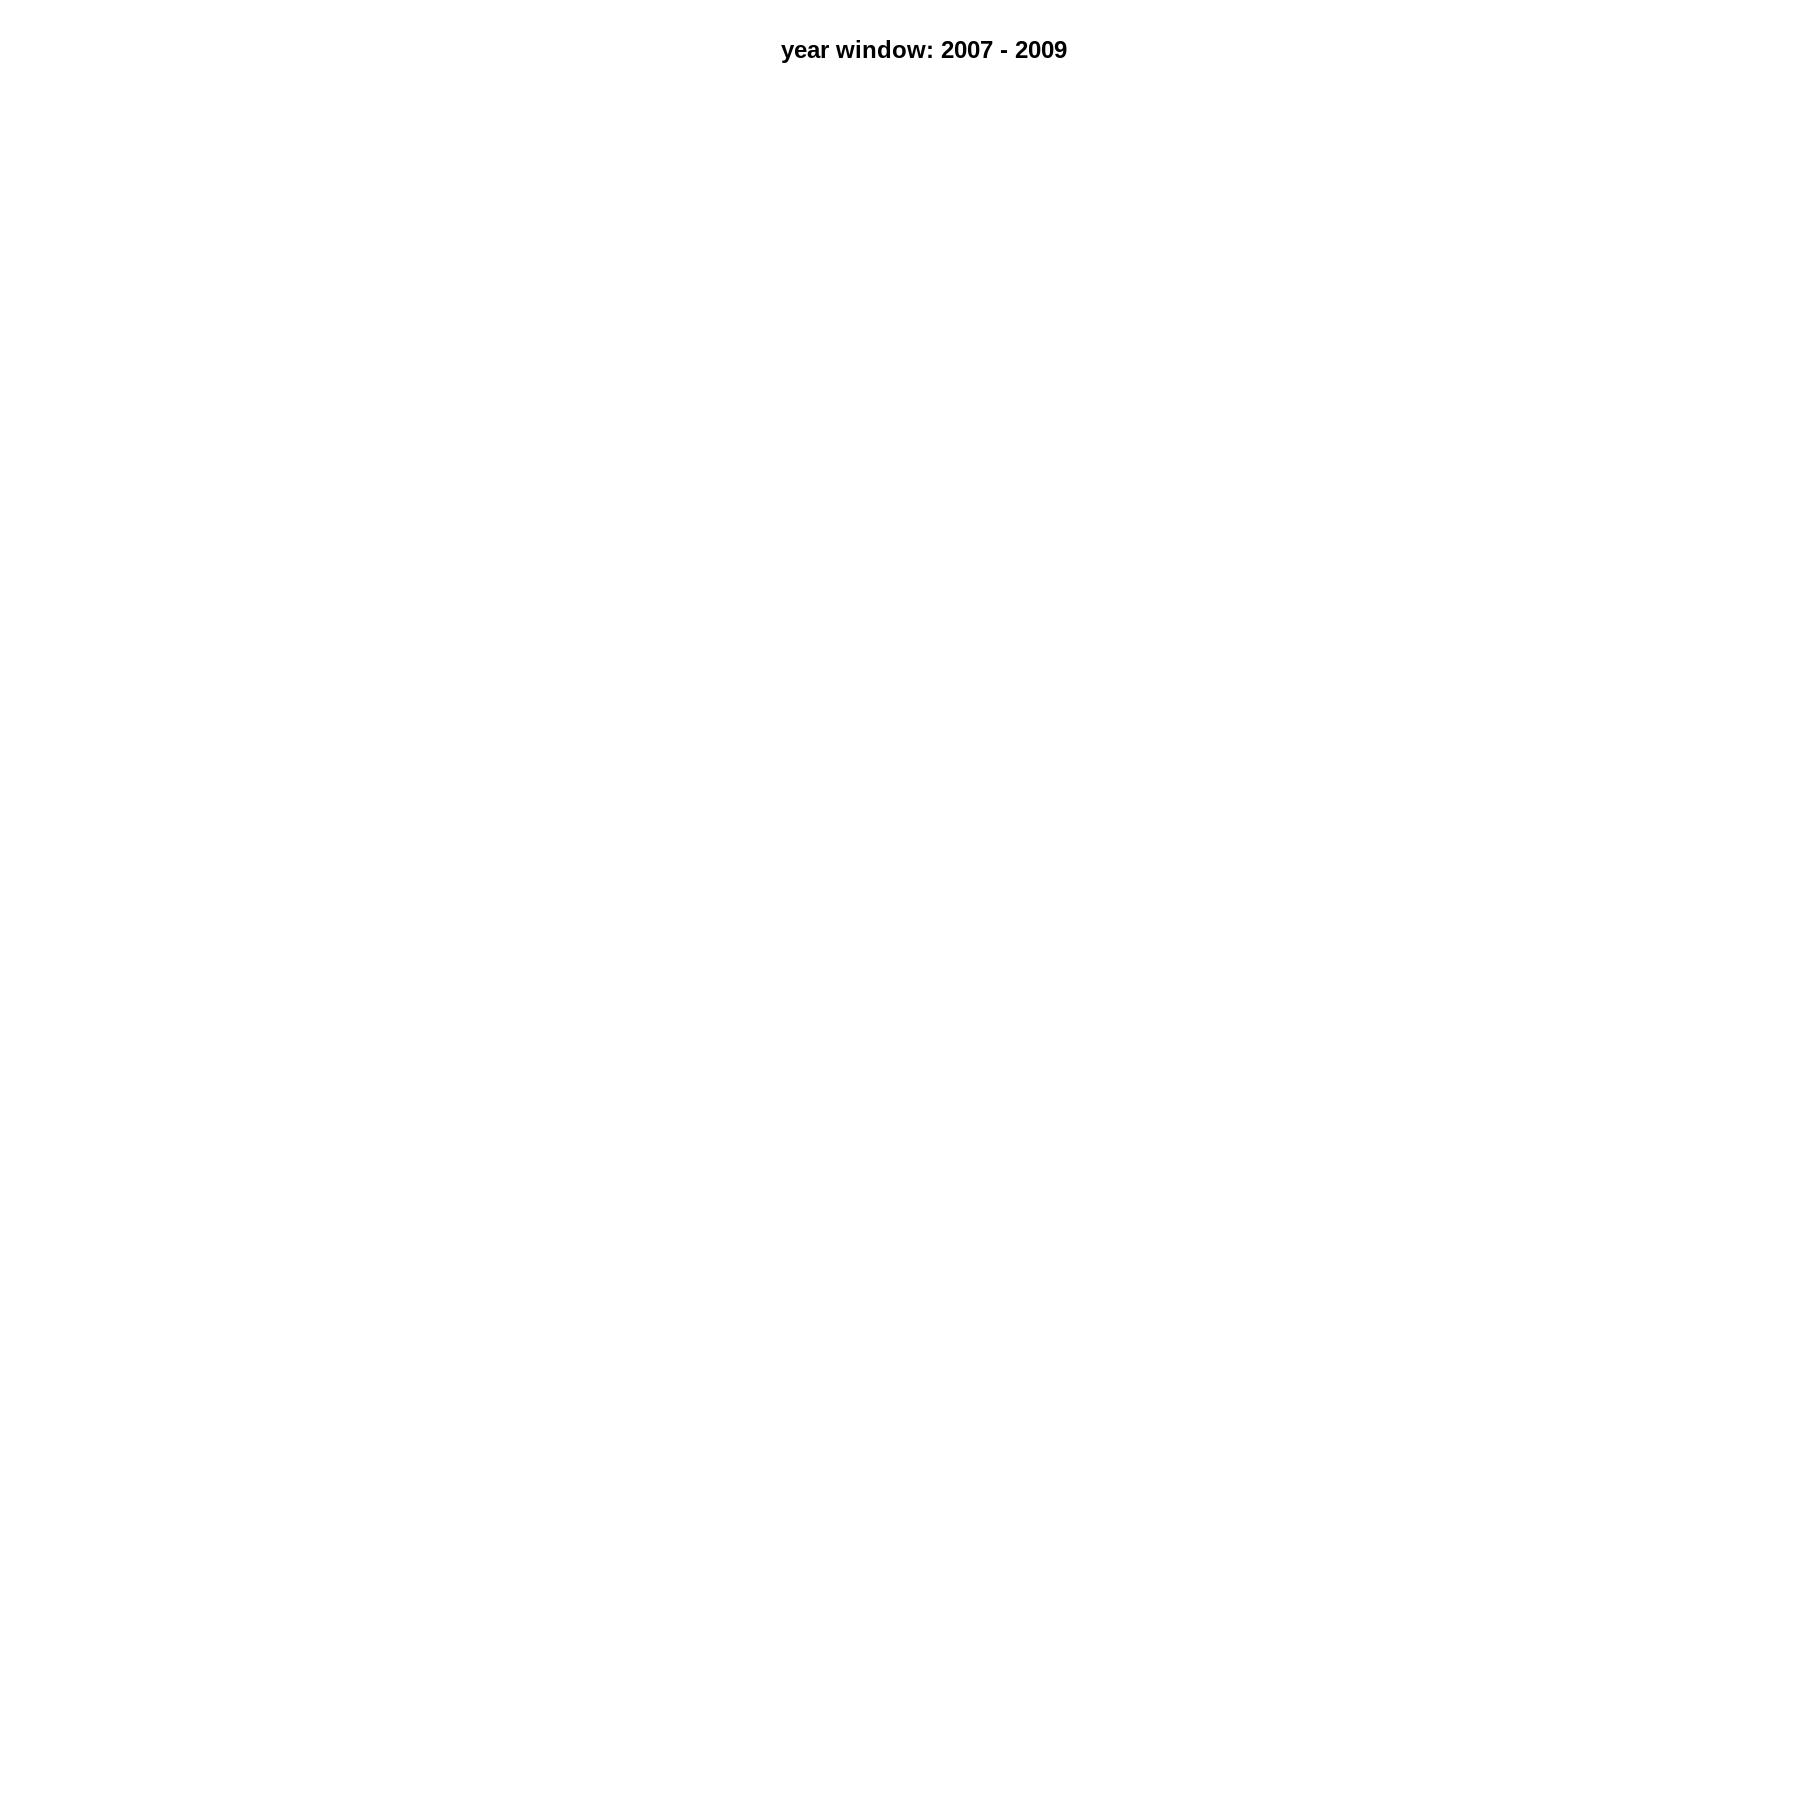

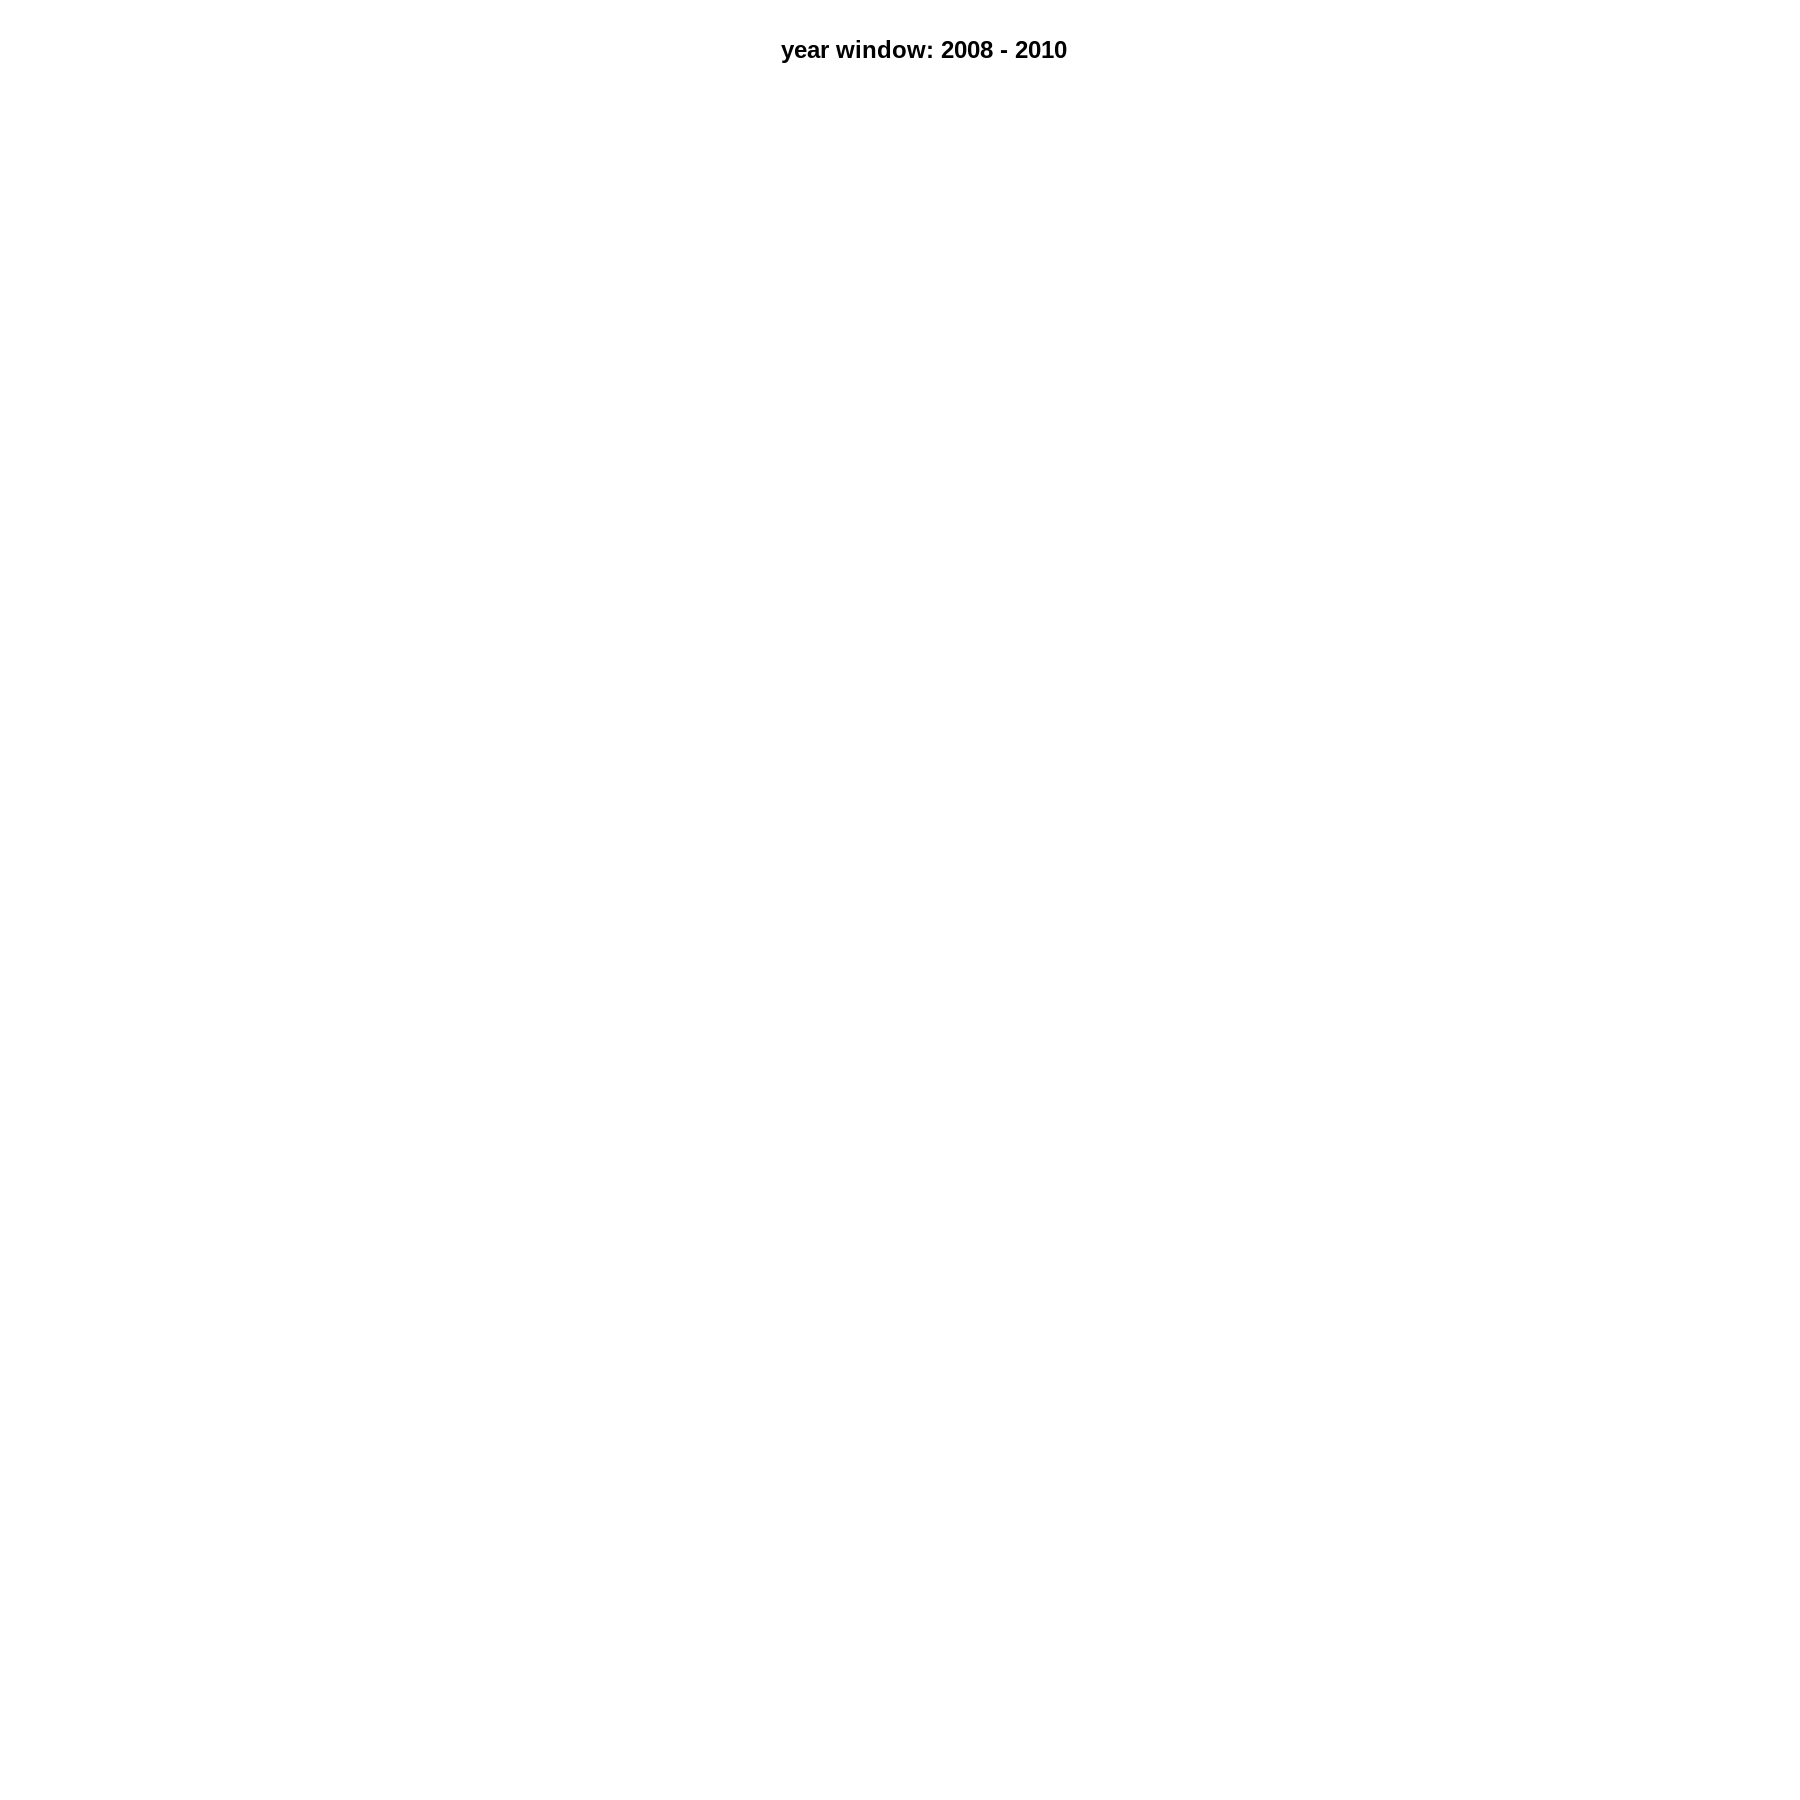

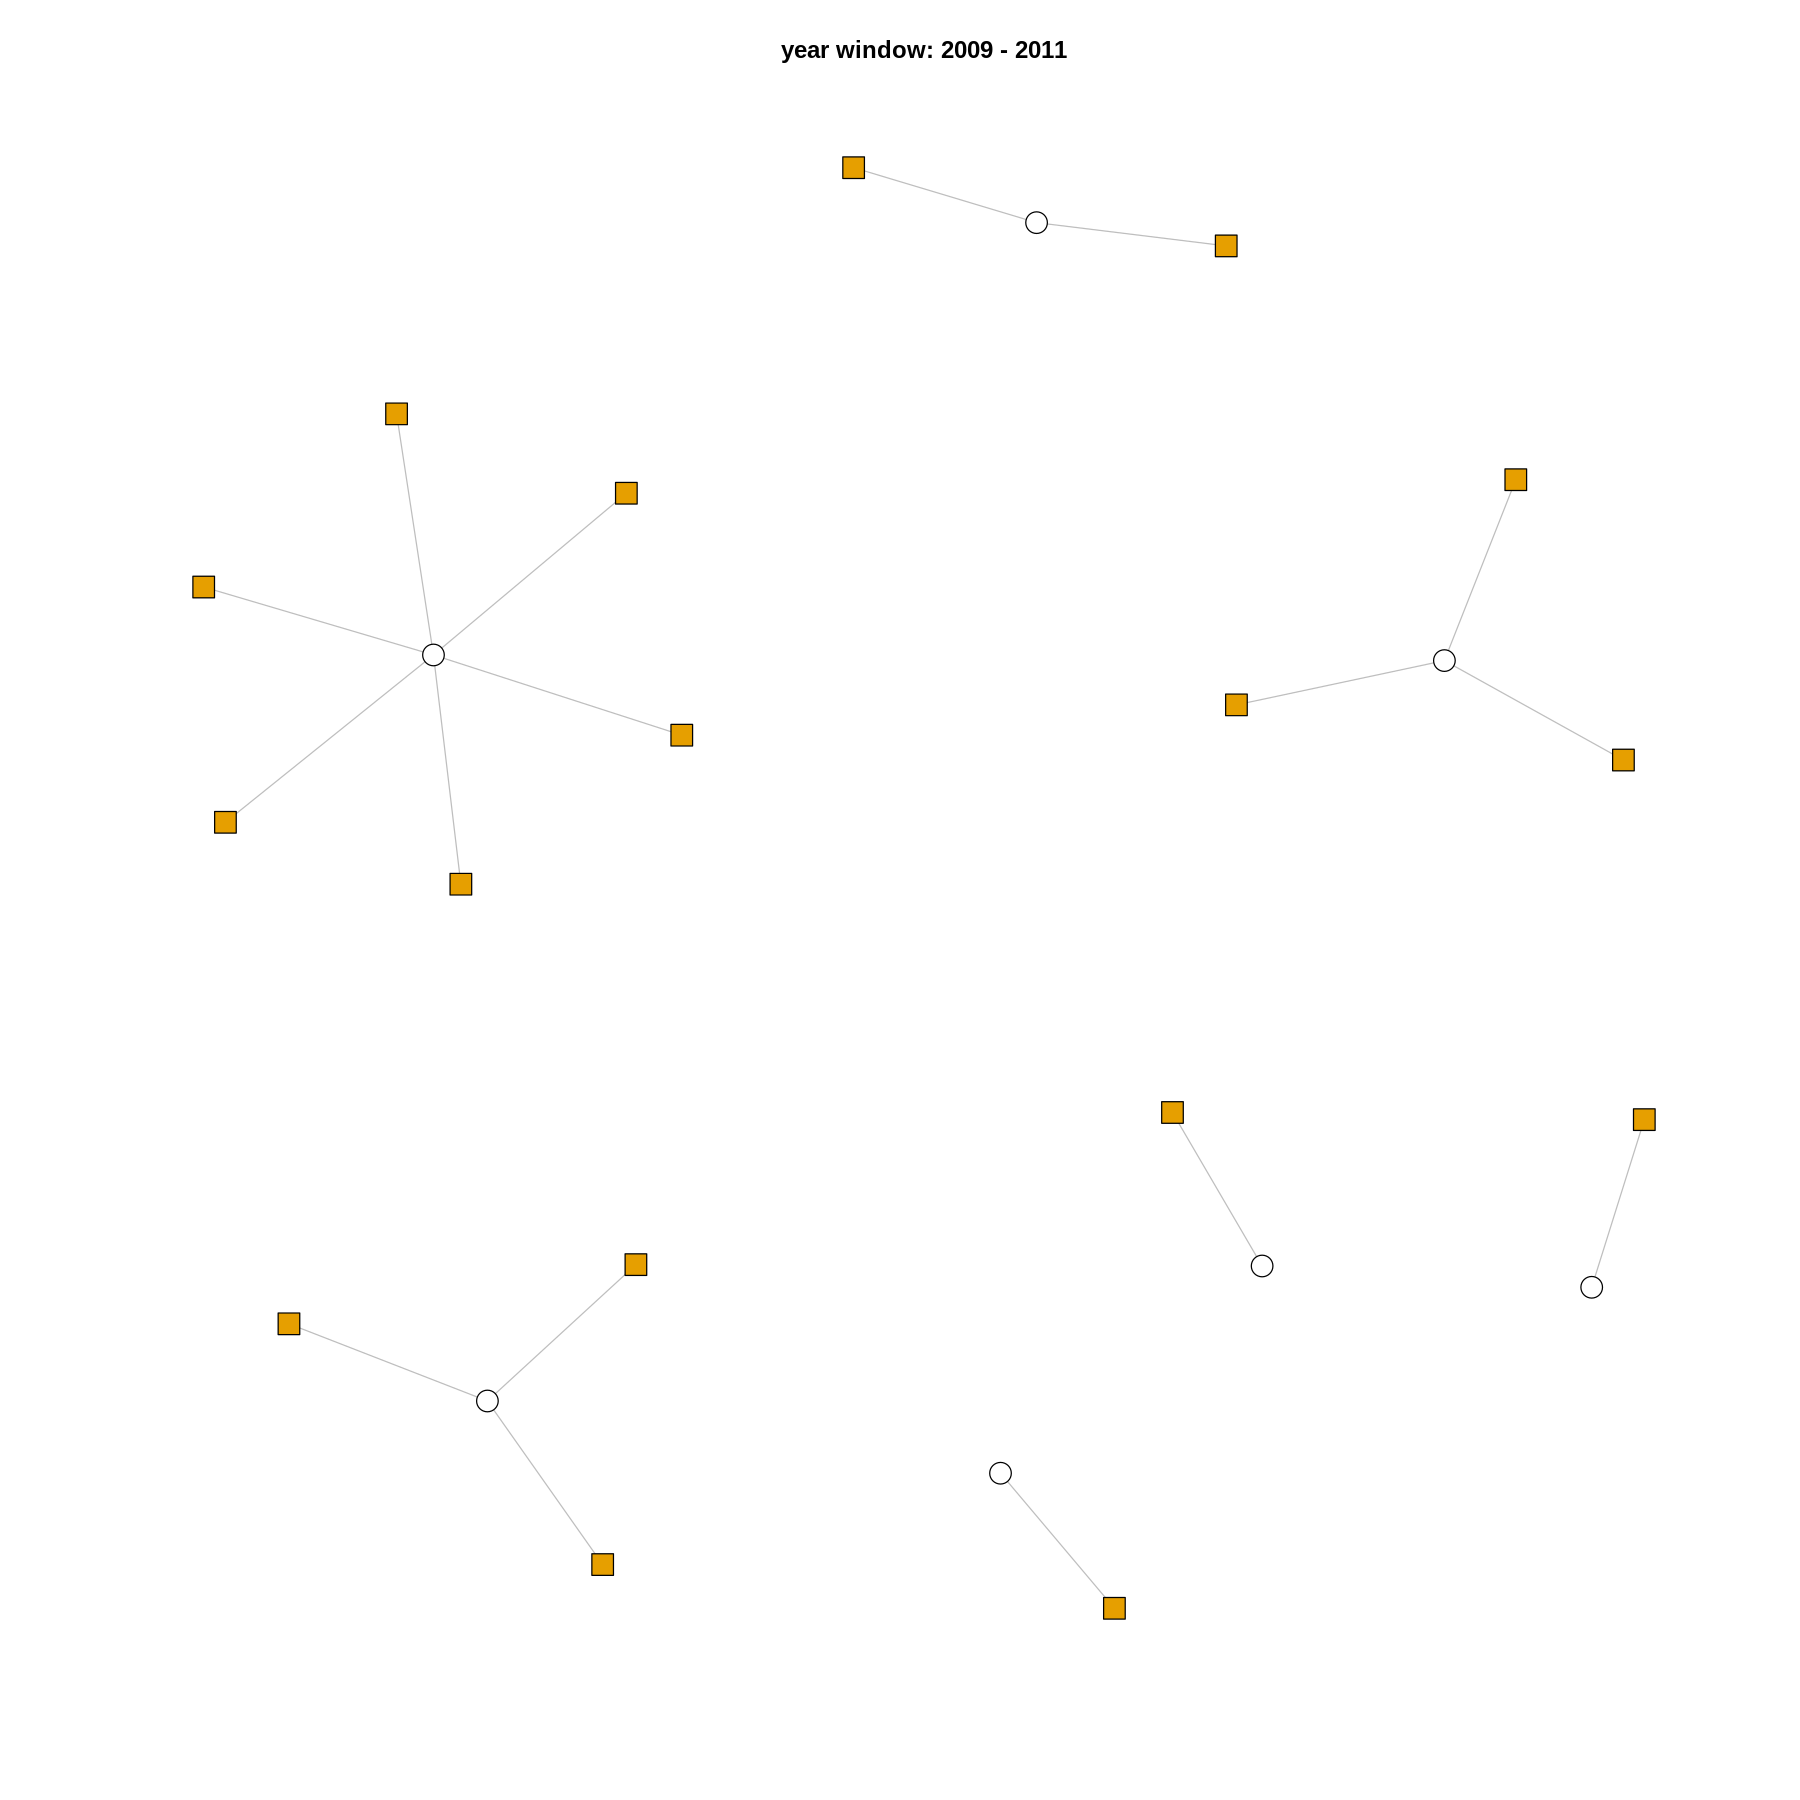

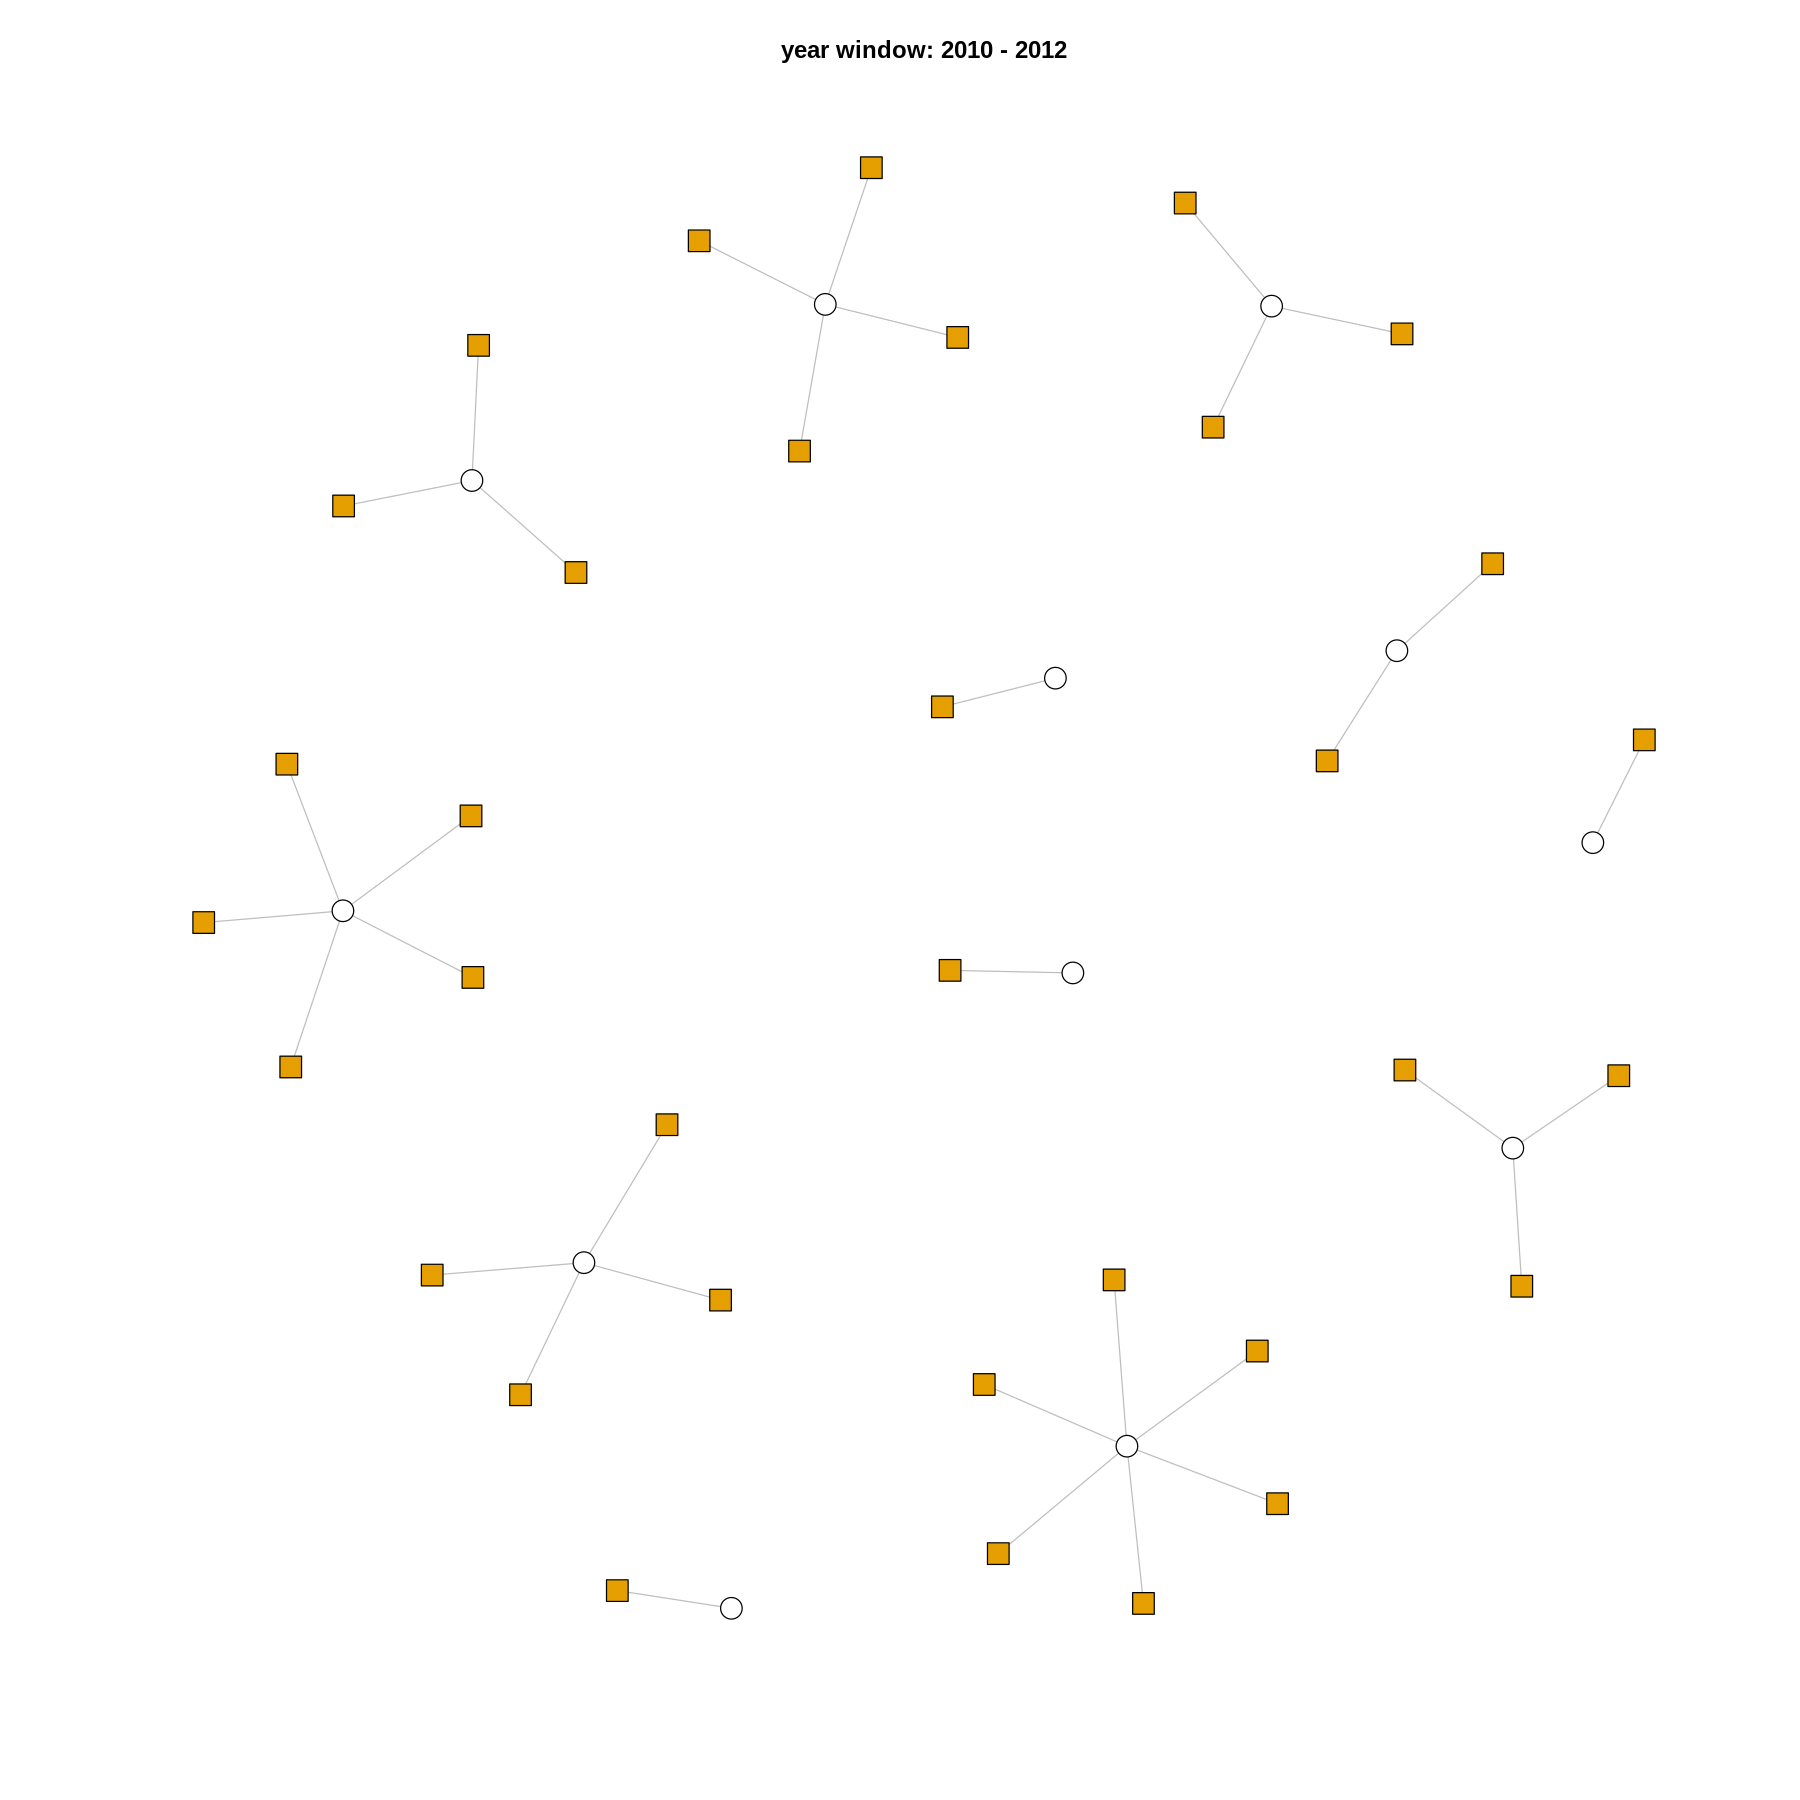

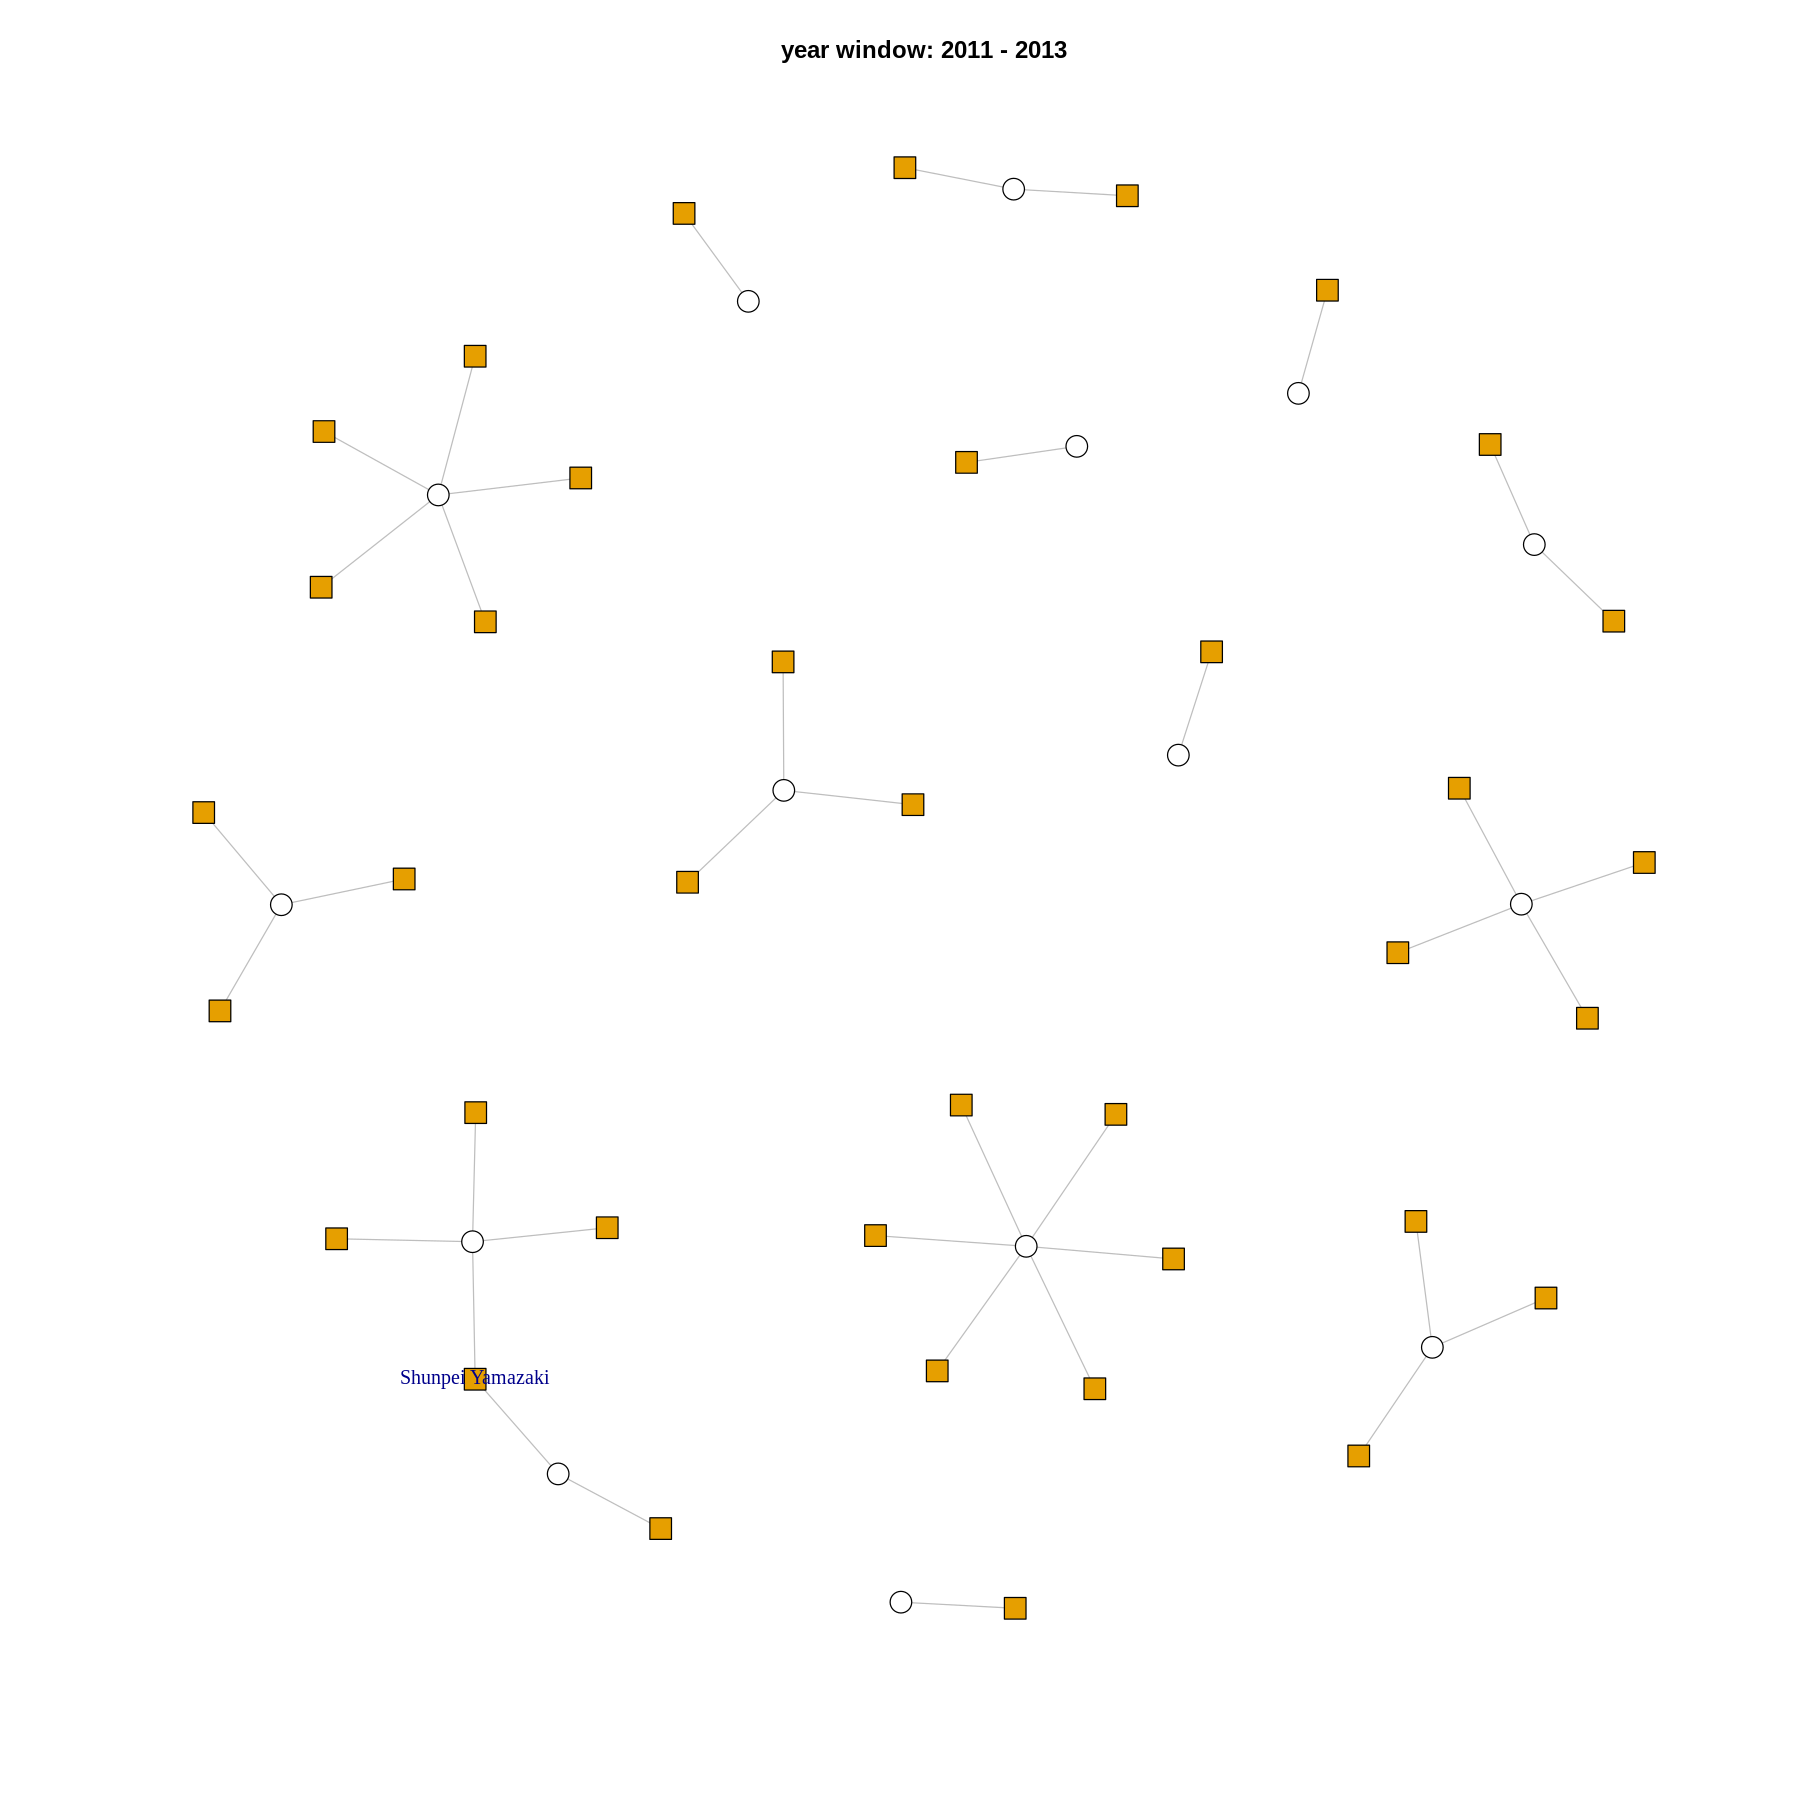

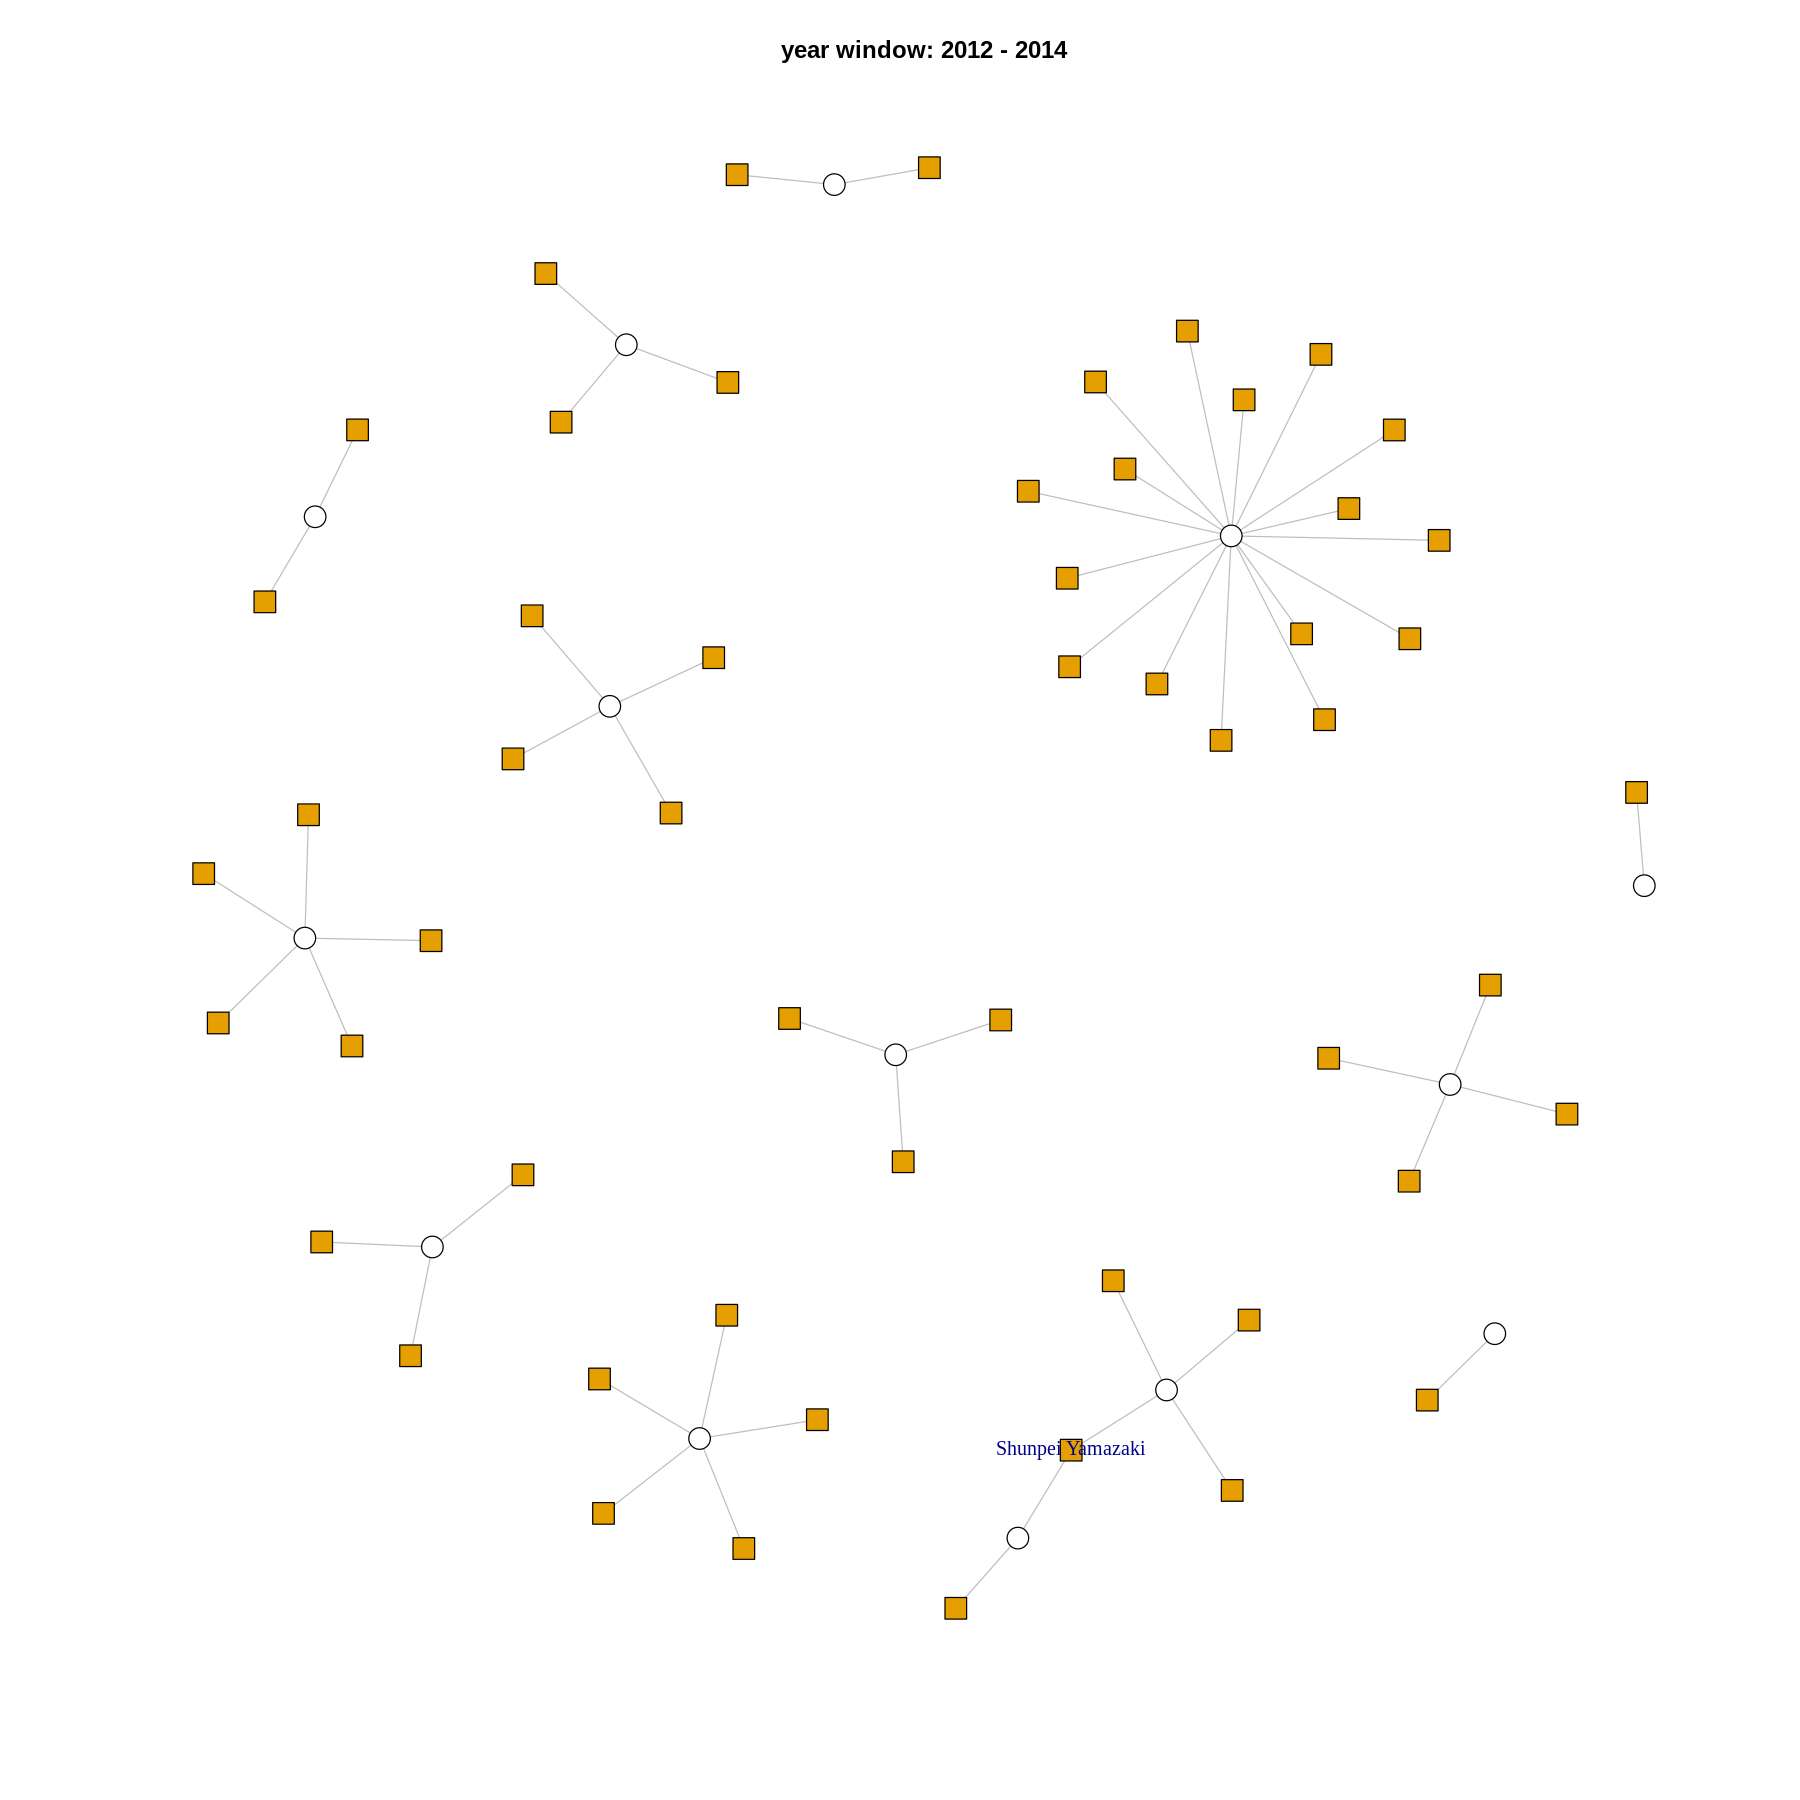

In [ ]:
window_width = 3
end = 2023 - window_width + 1
degree_threshold = 1
for (start_year in 2006:end) {
  edgelist <- window_patent_inventor_edgelist(window_width, start_year)
  graph <- bipartite_graph(edgelist)
  plotting_key_inventors(graph, degree_threshold)
}


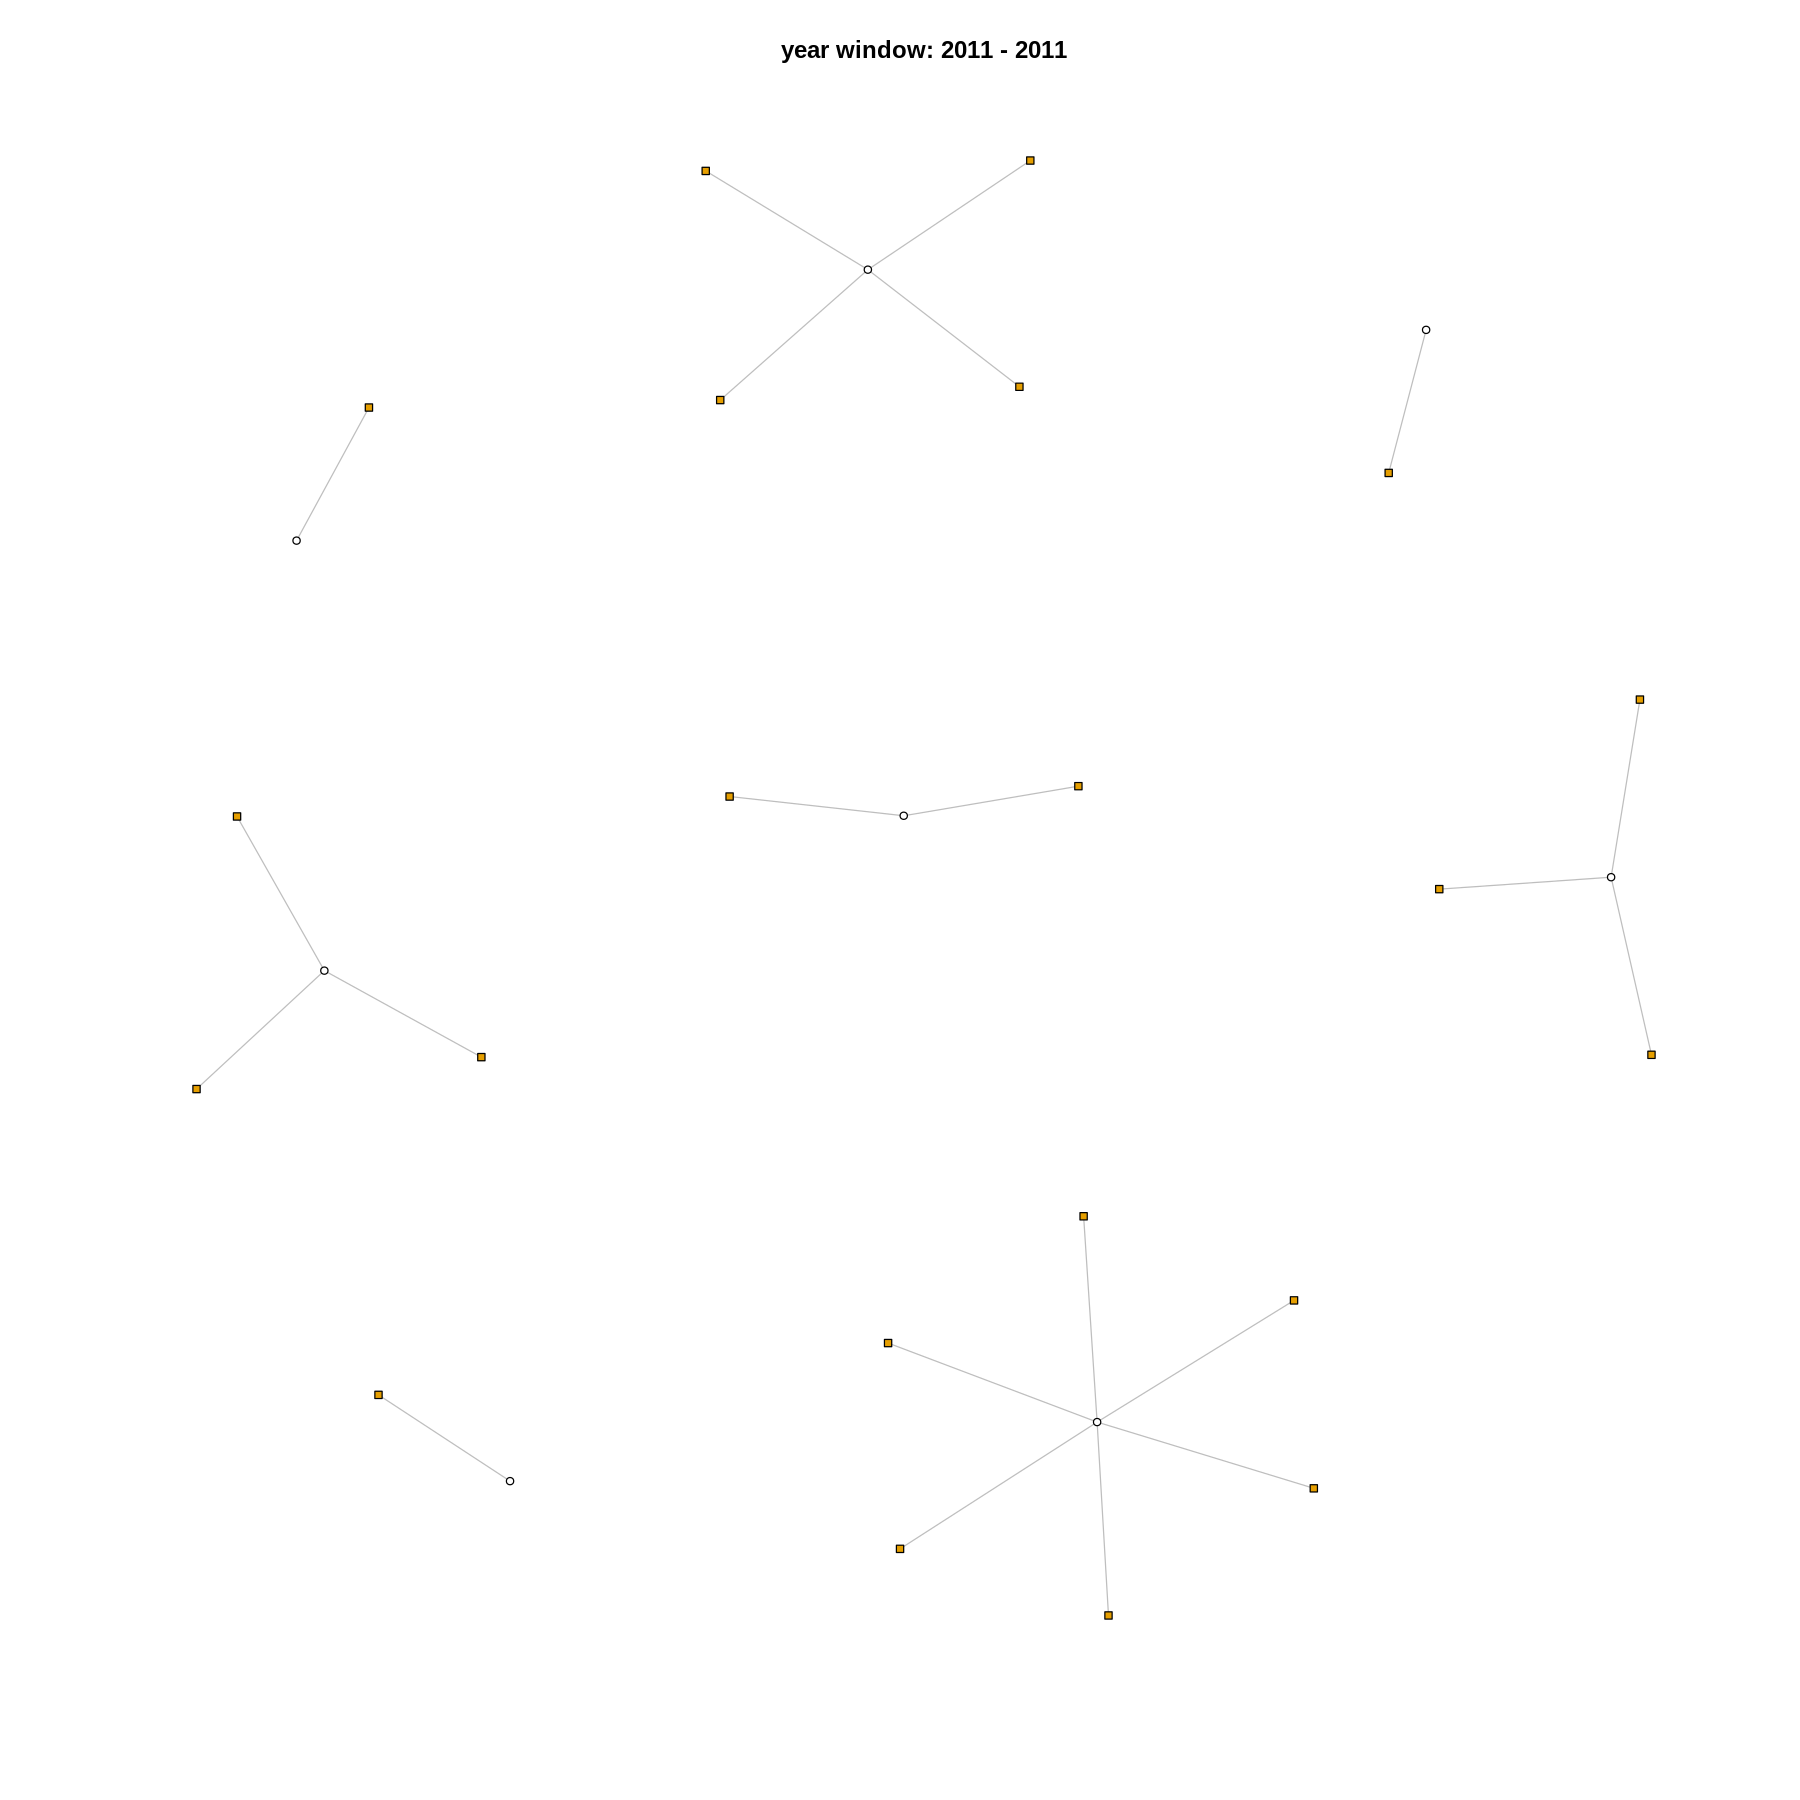

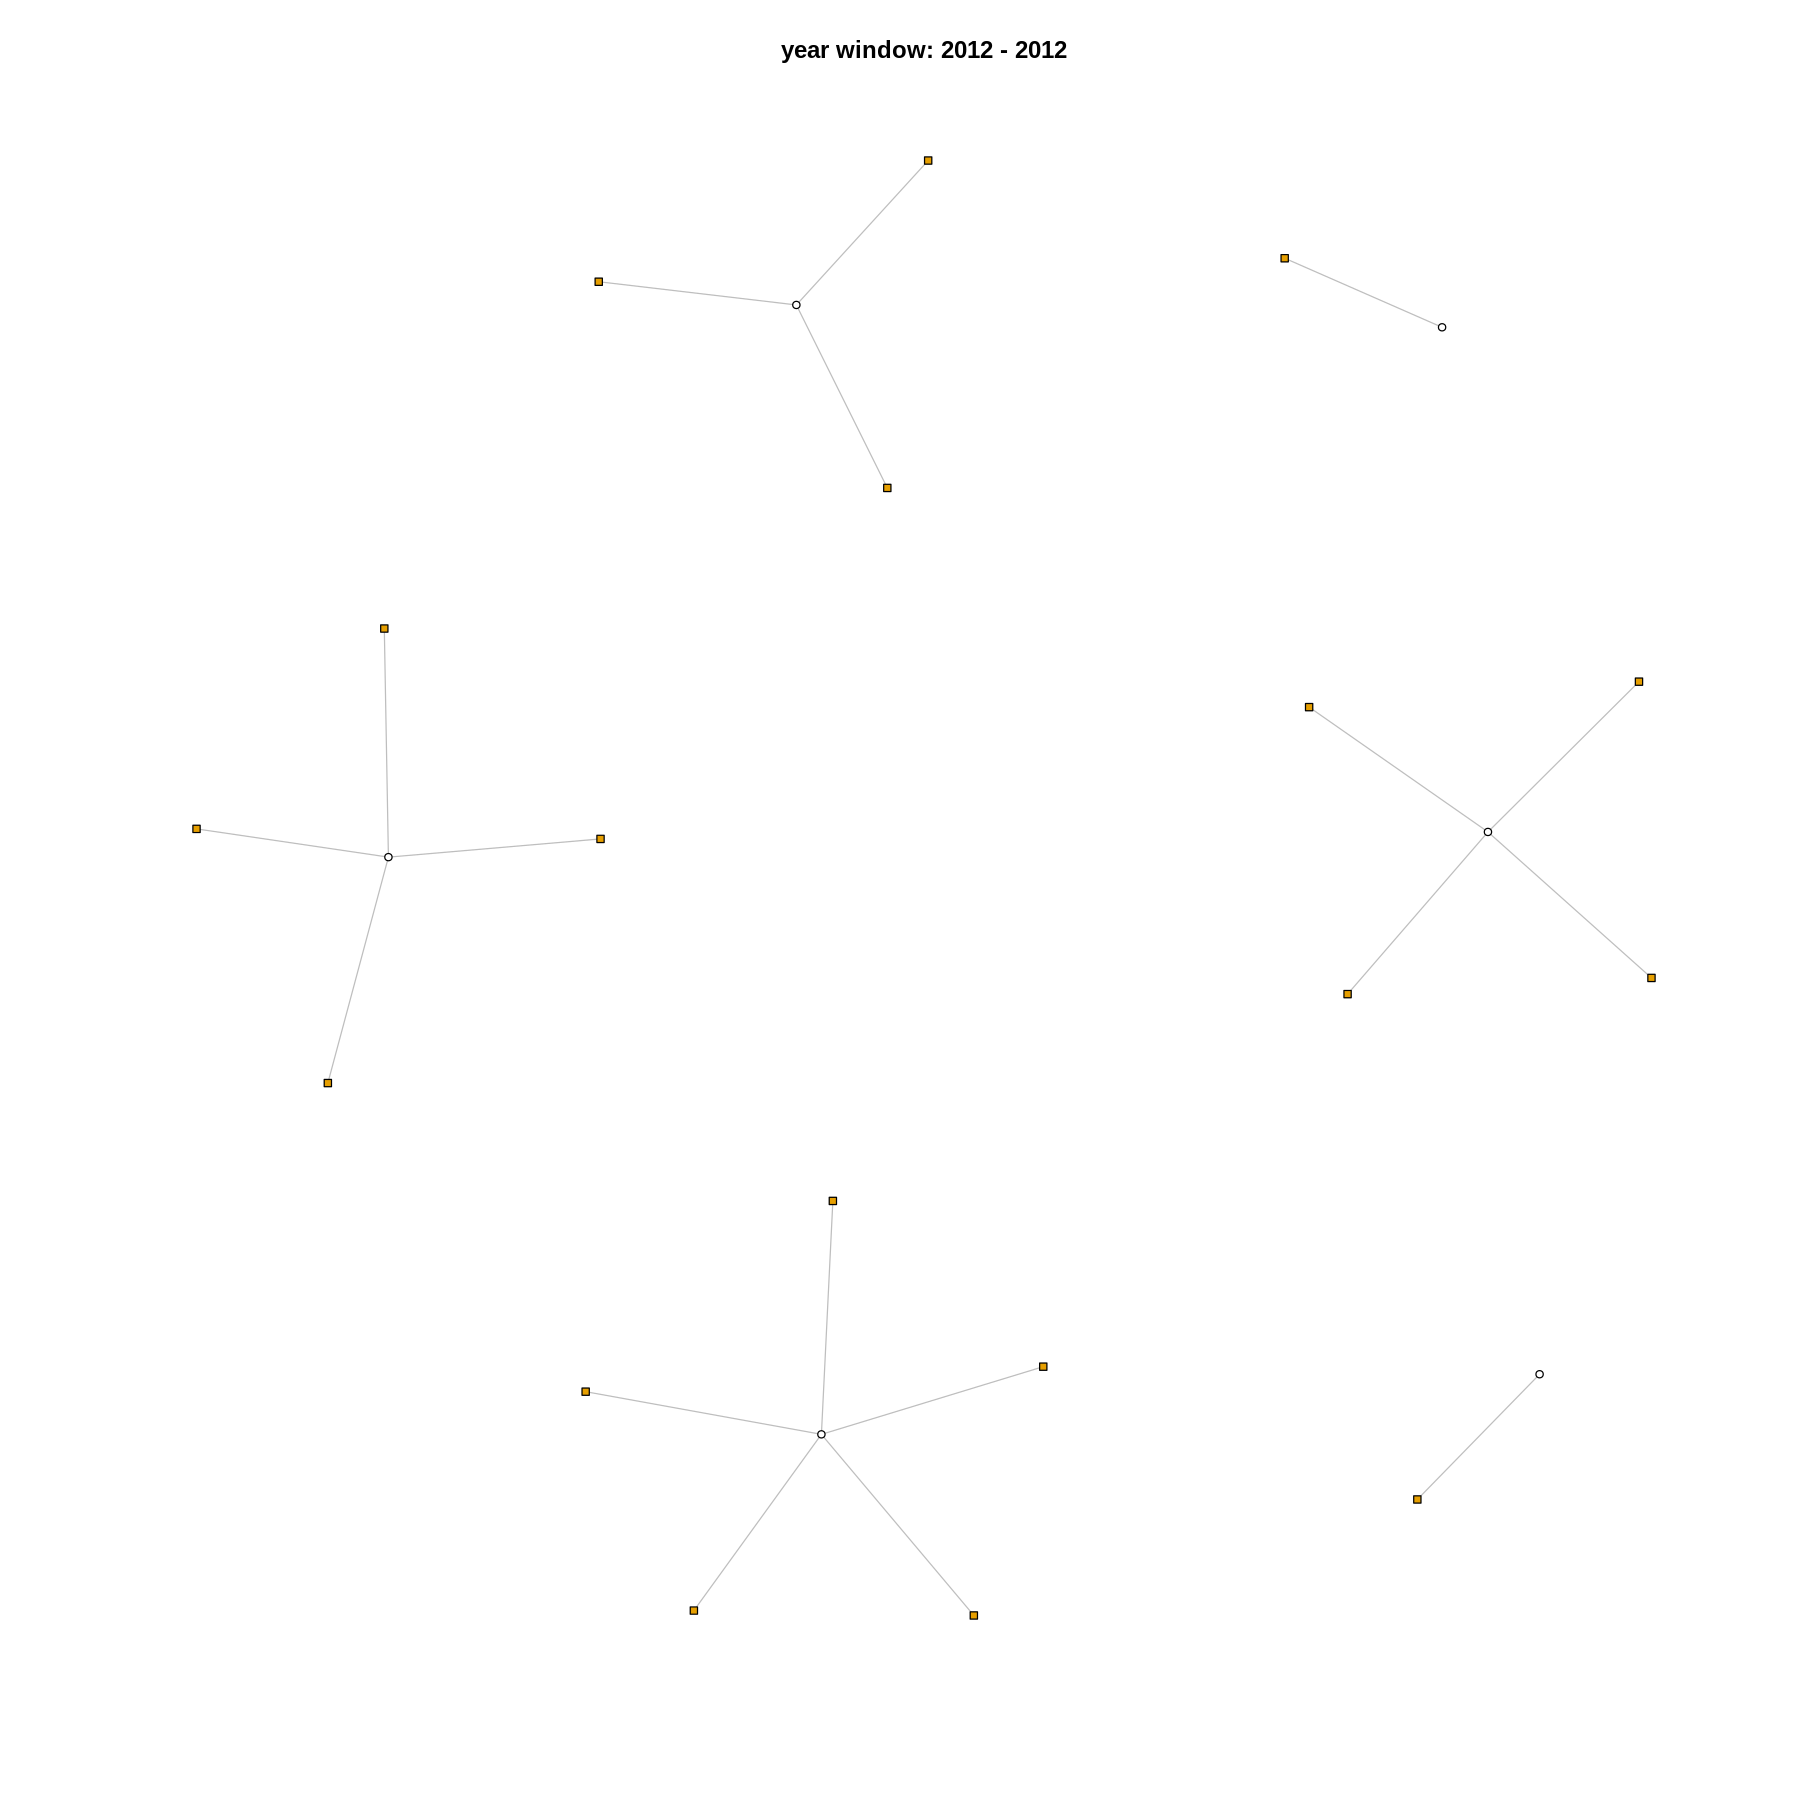

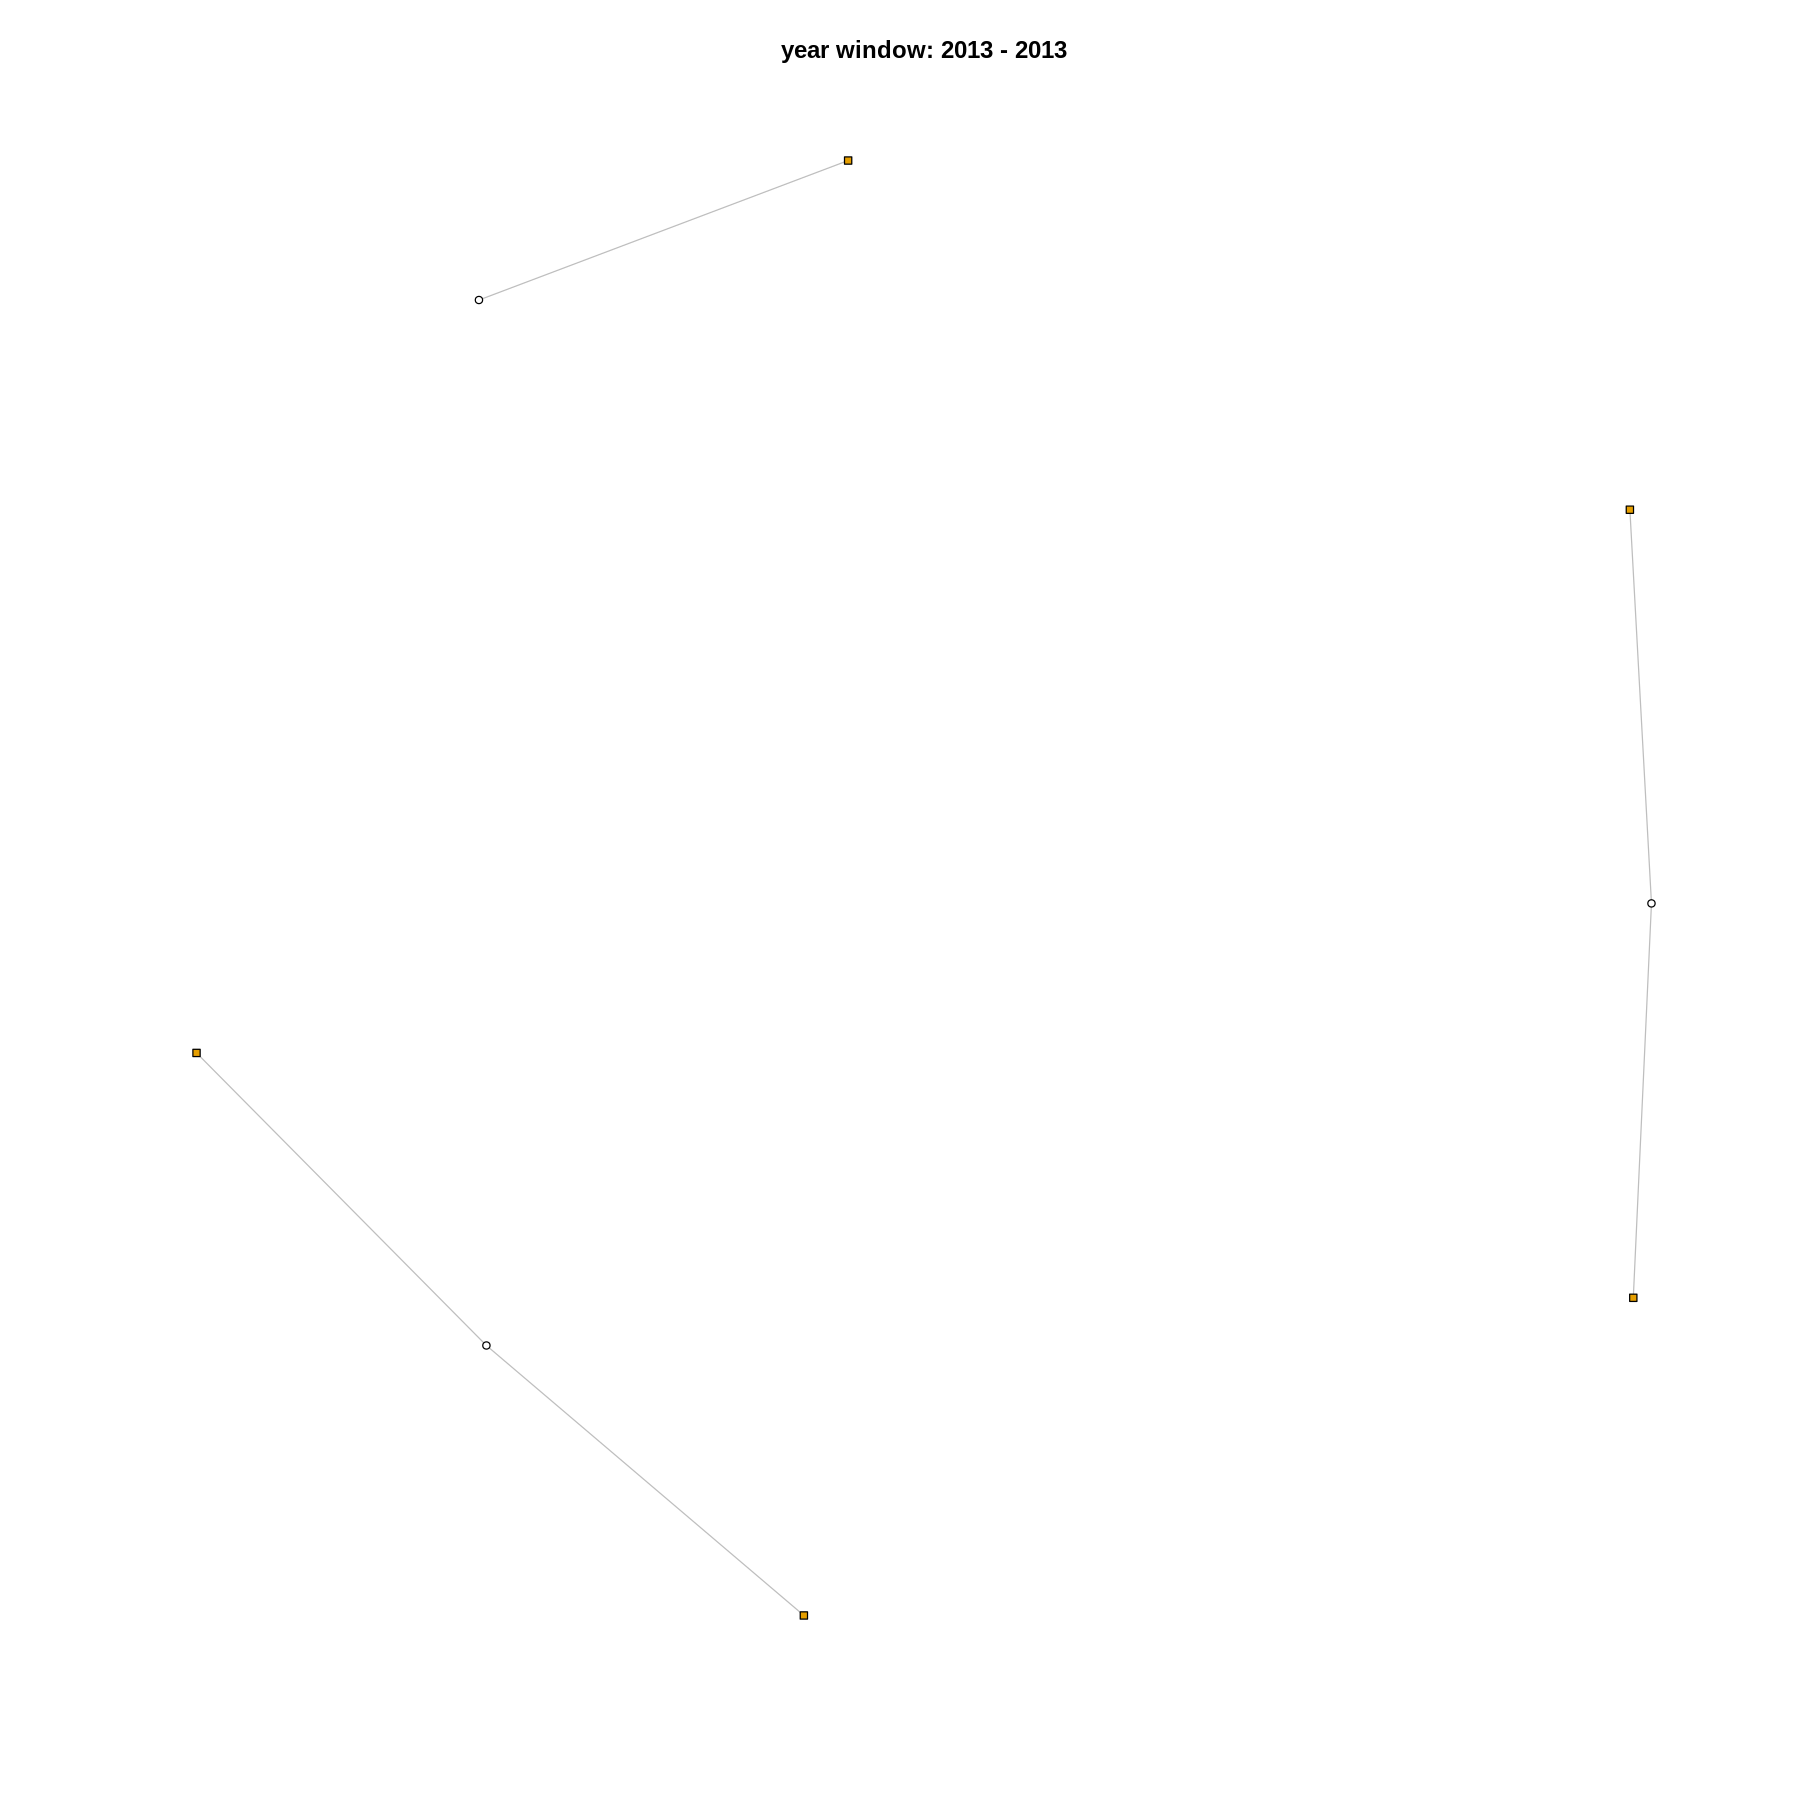

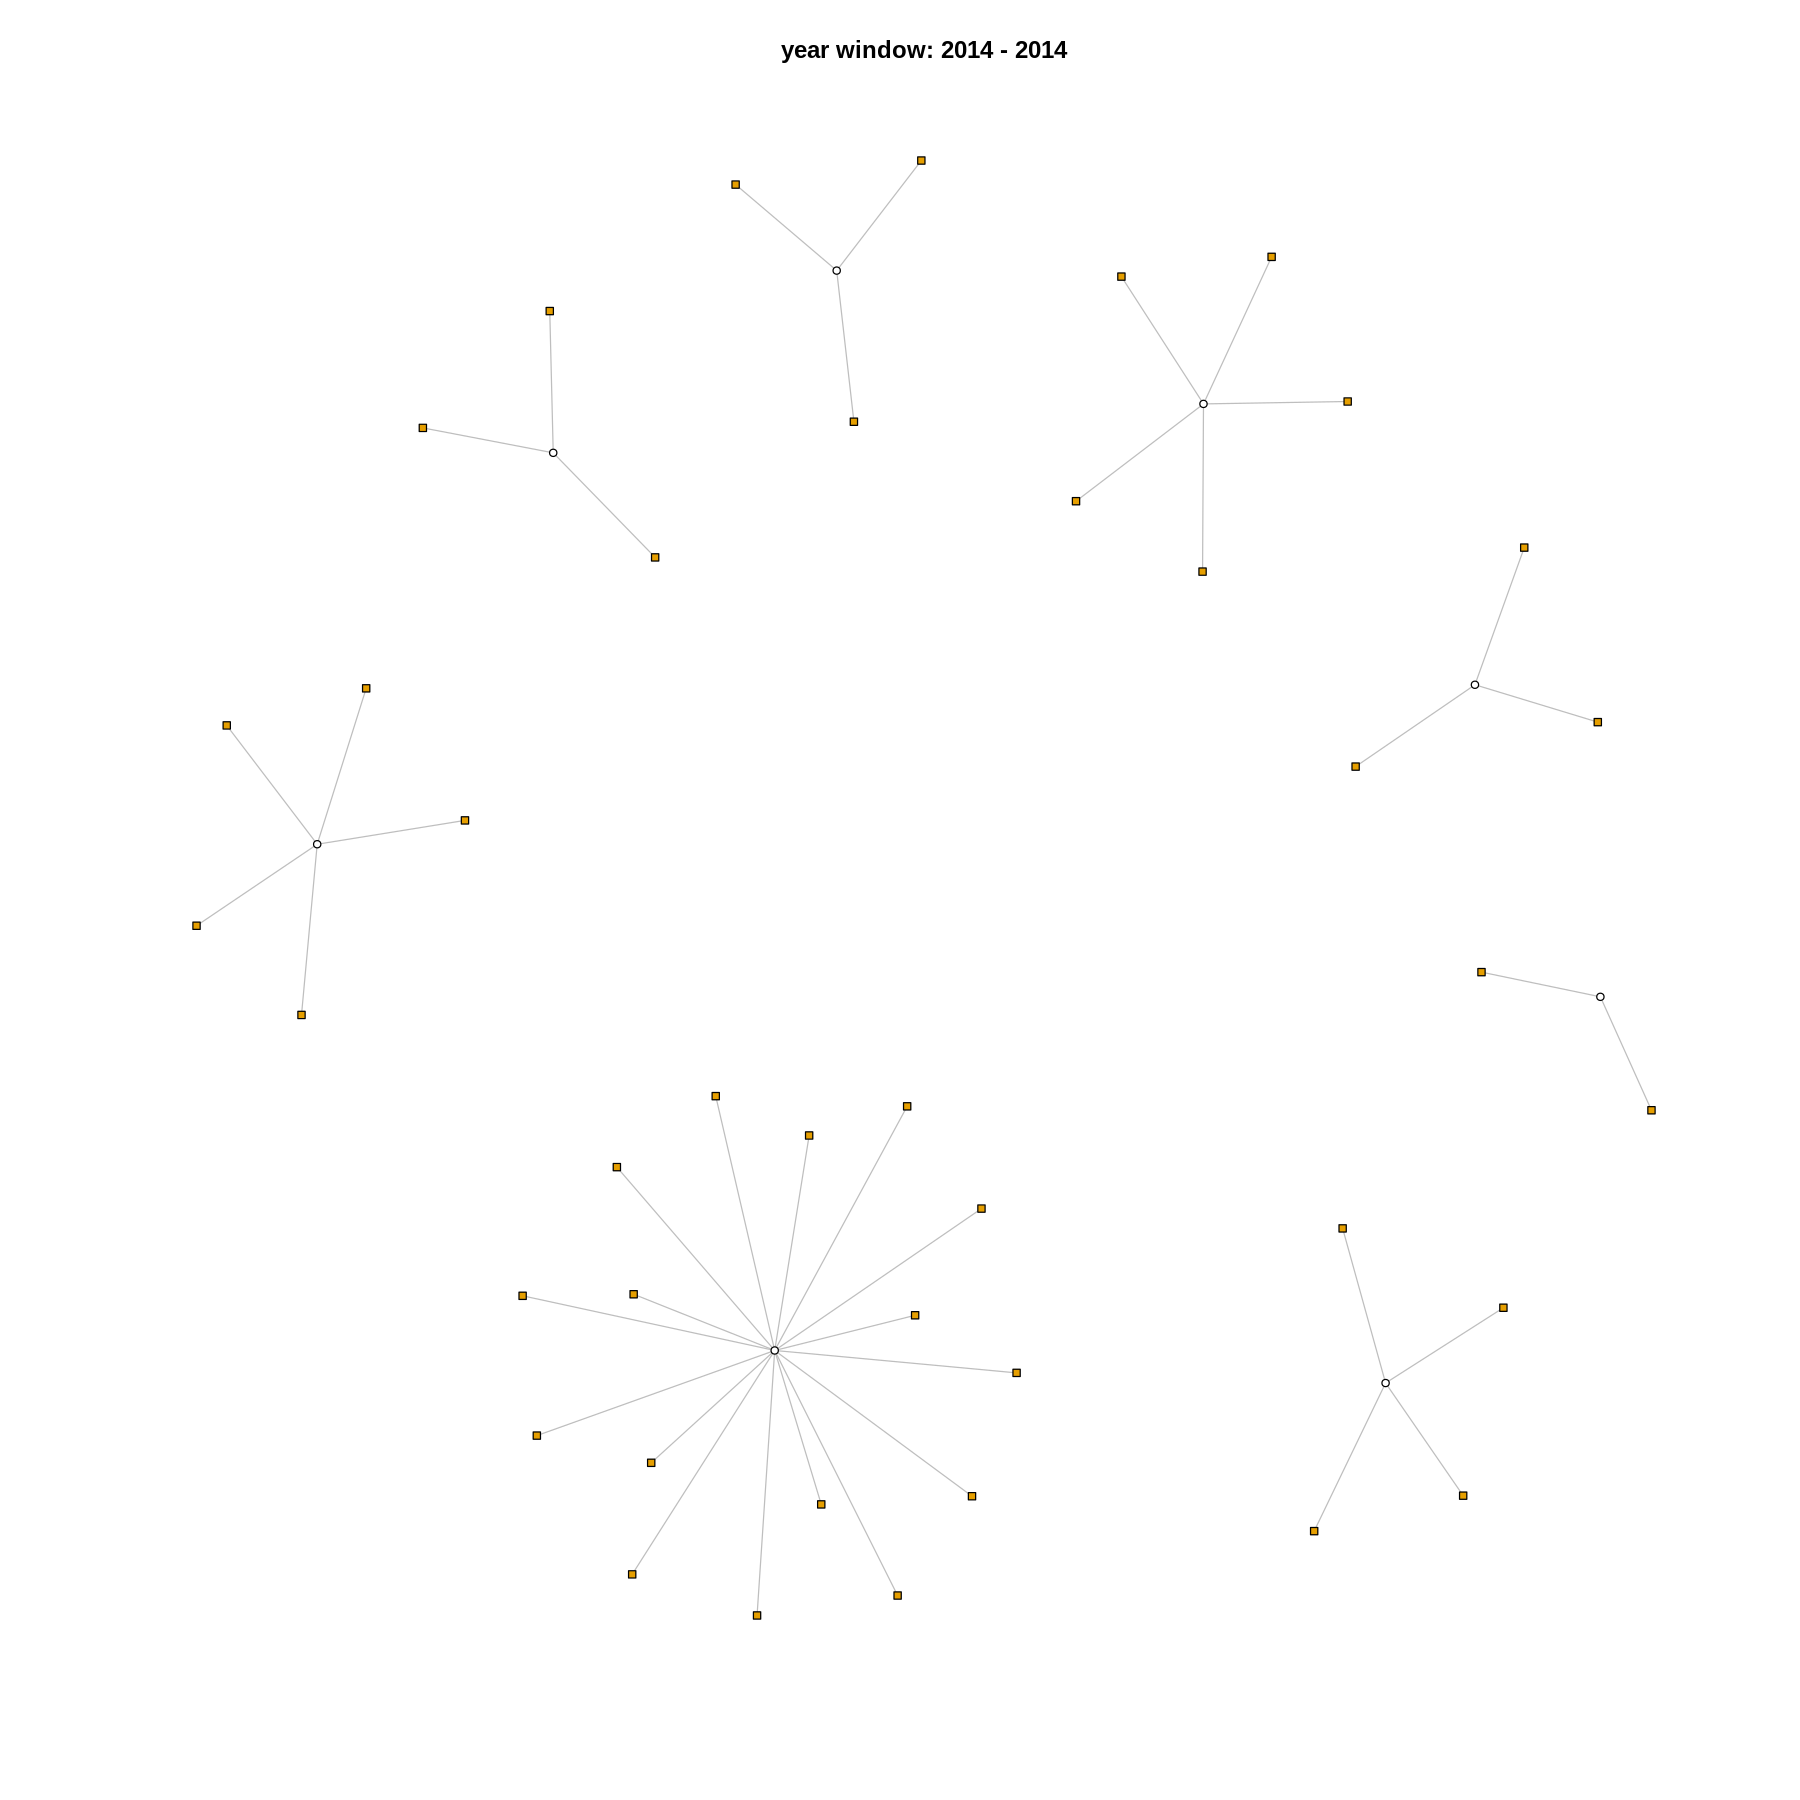

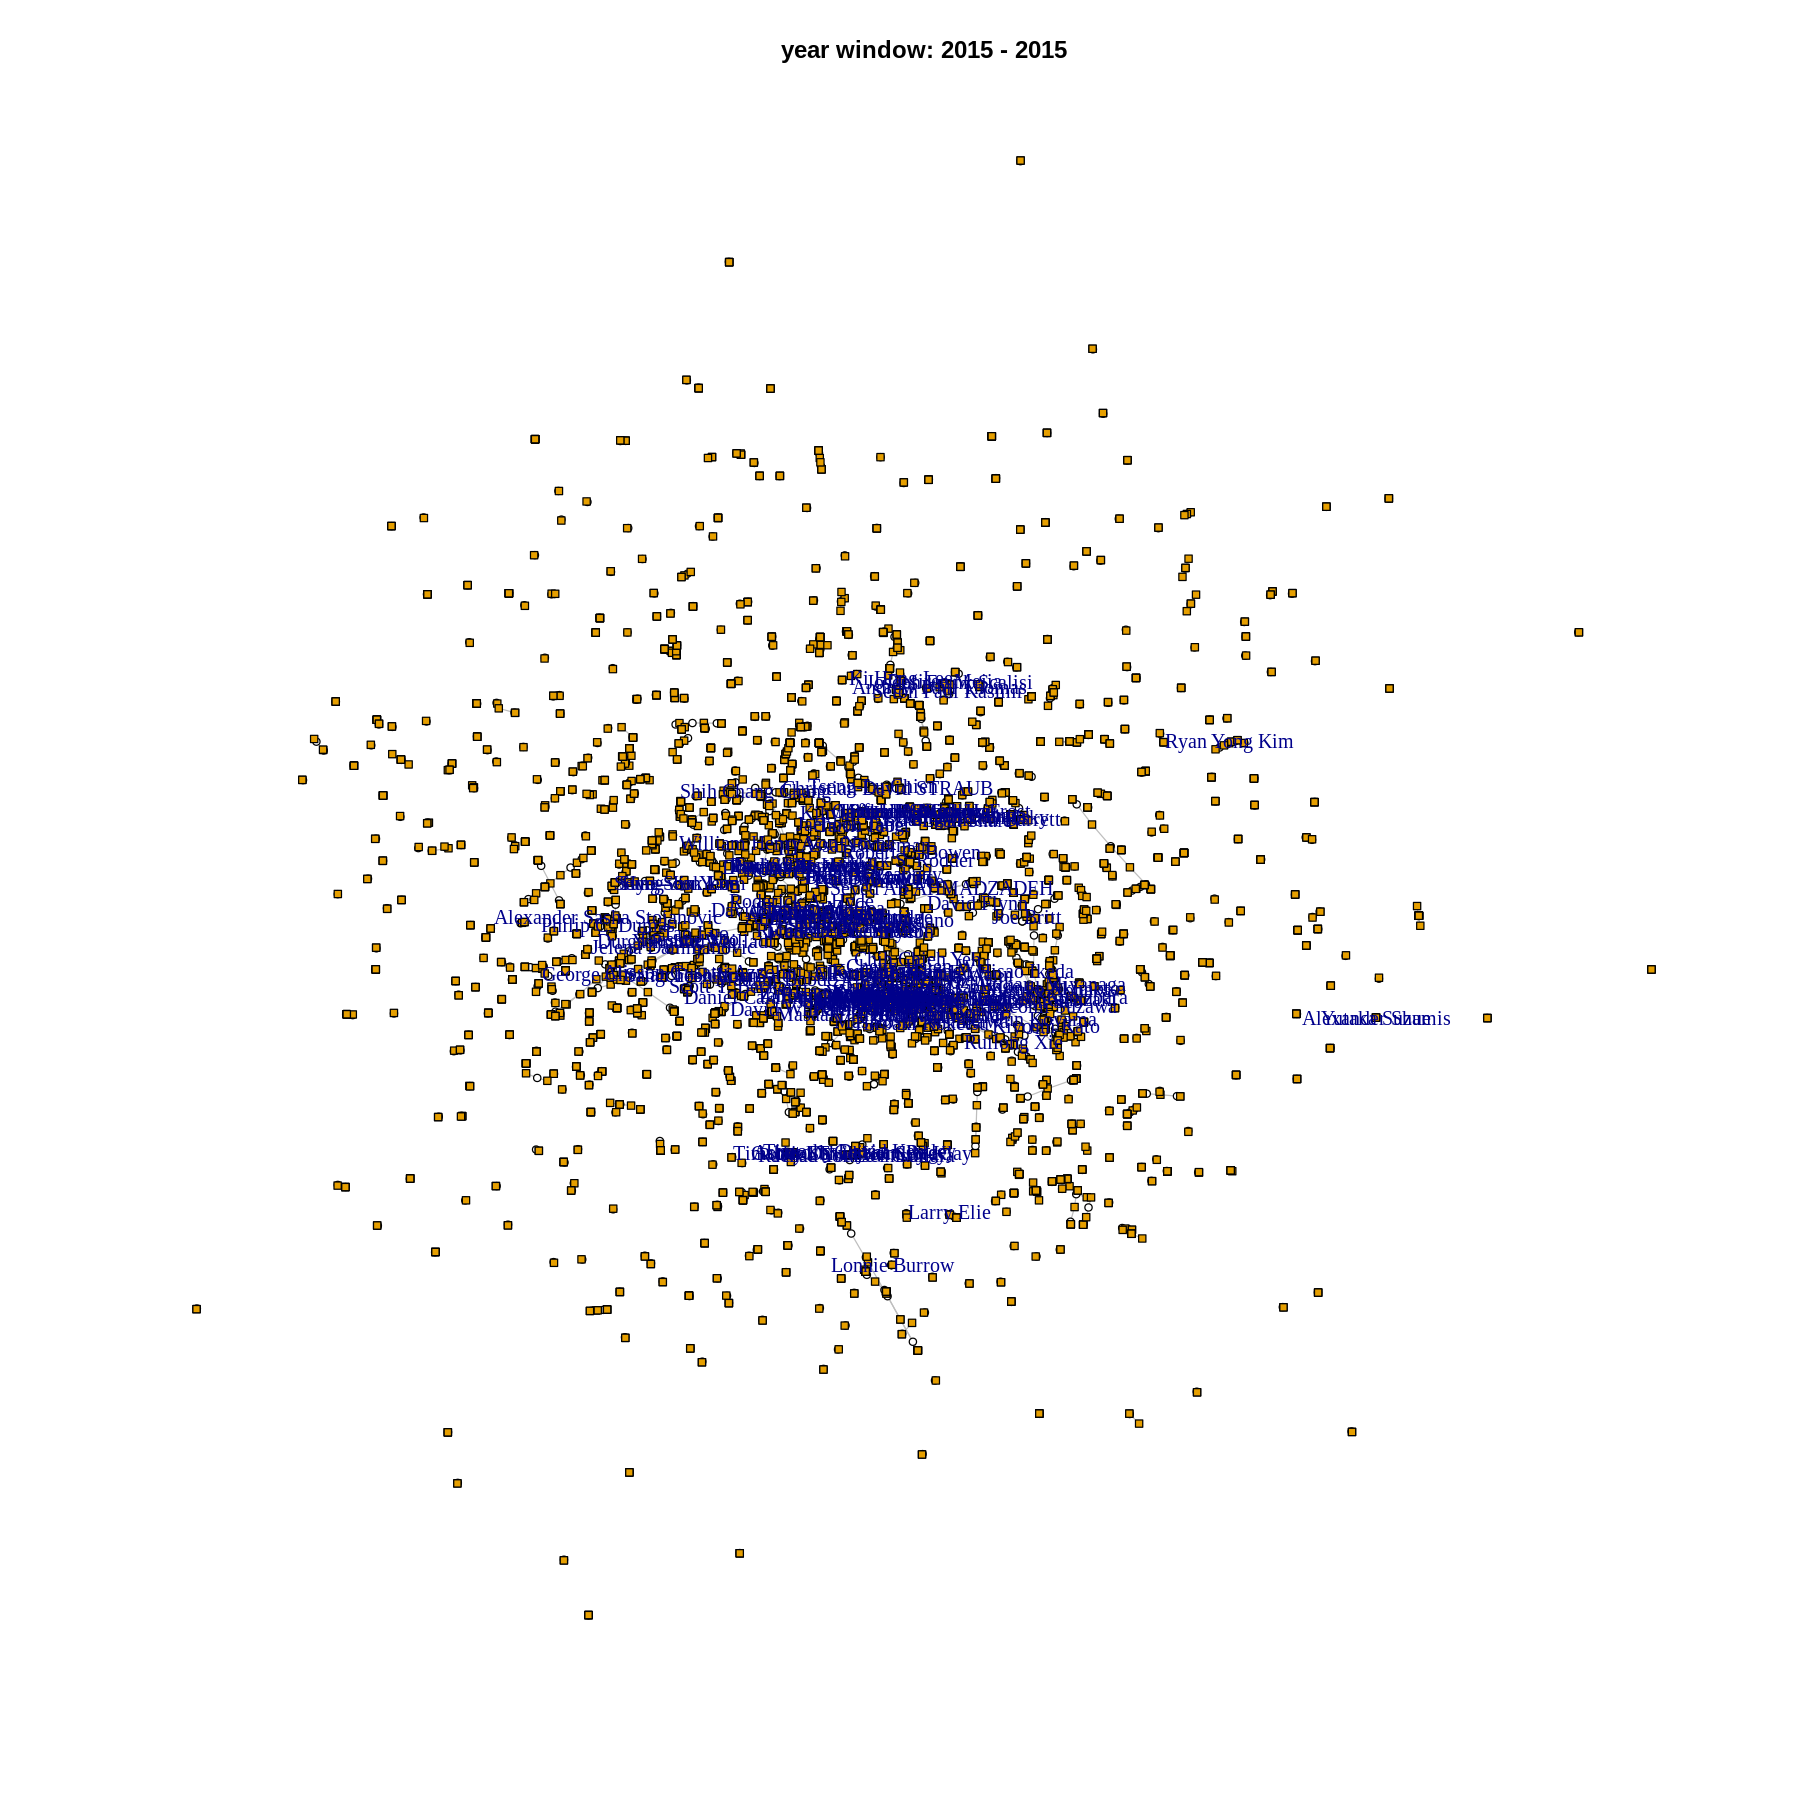

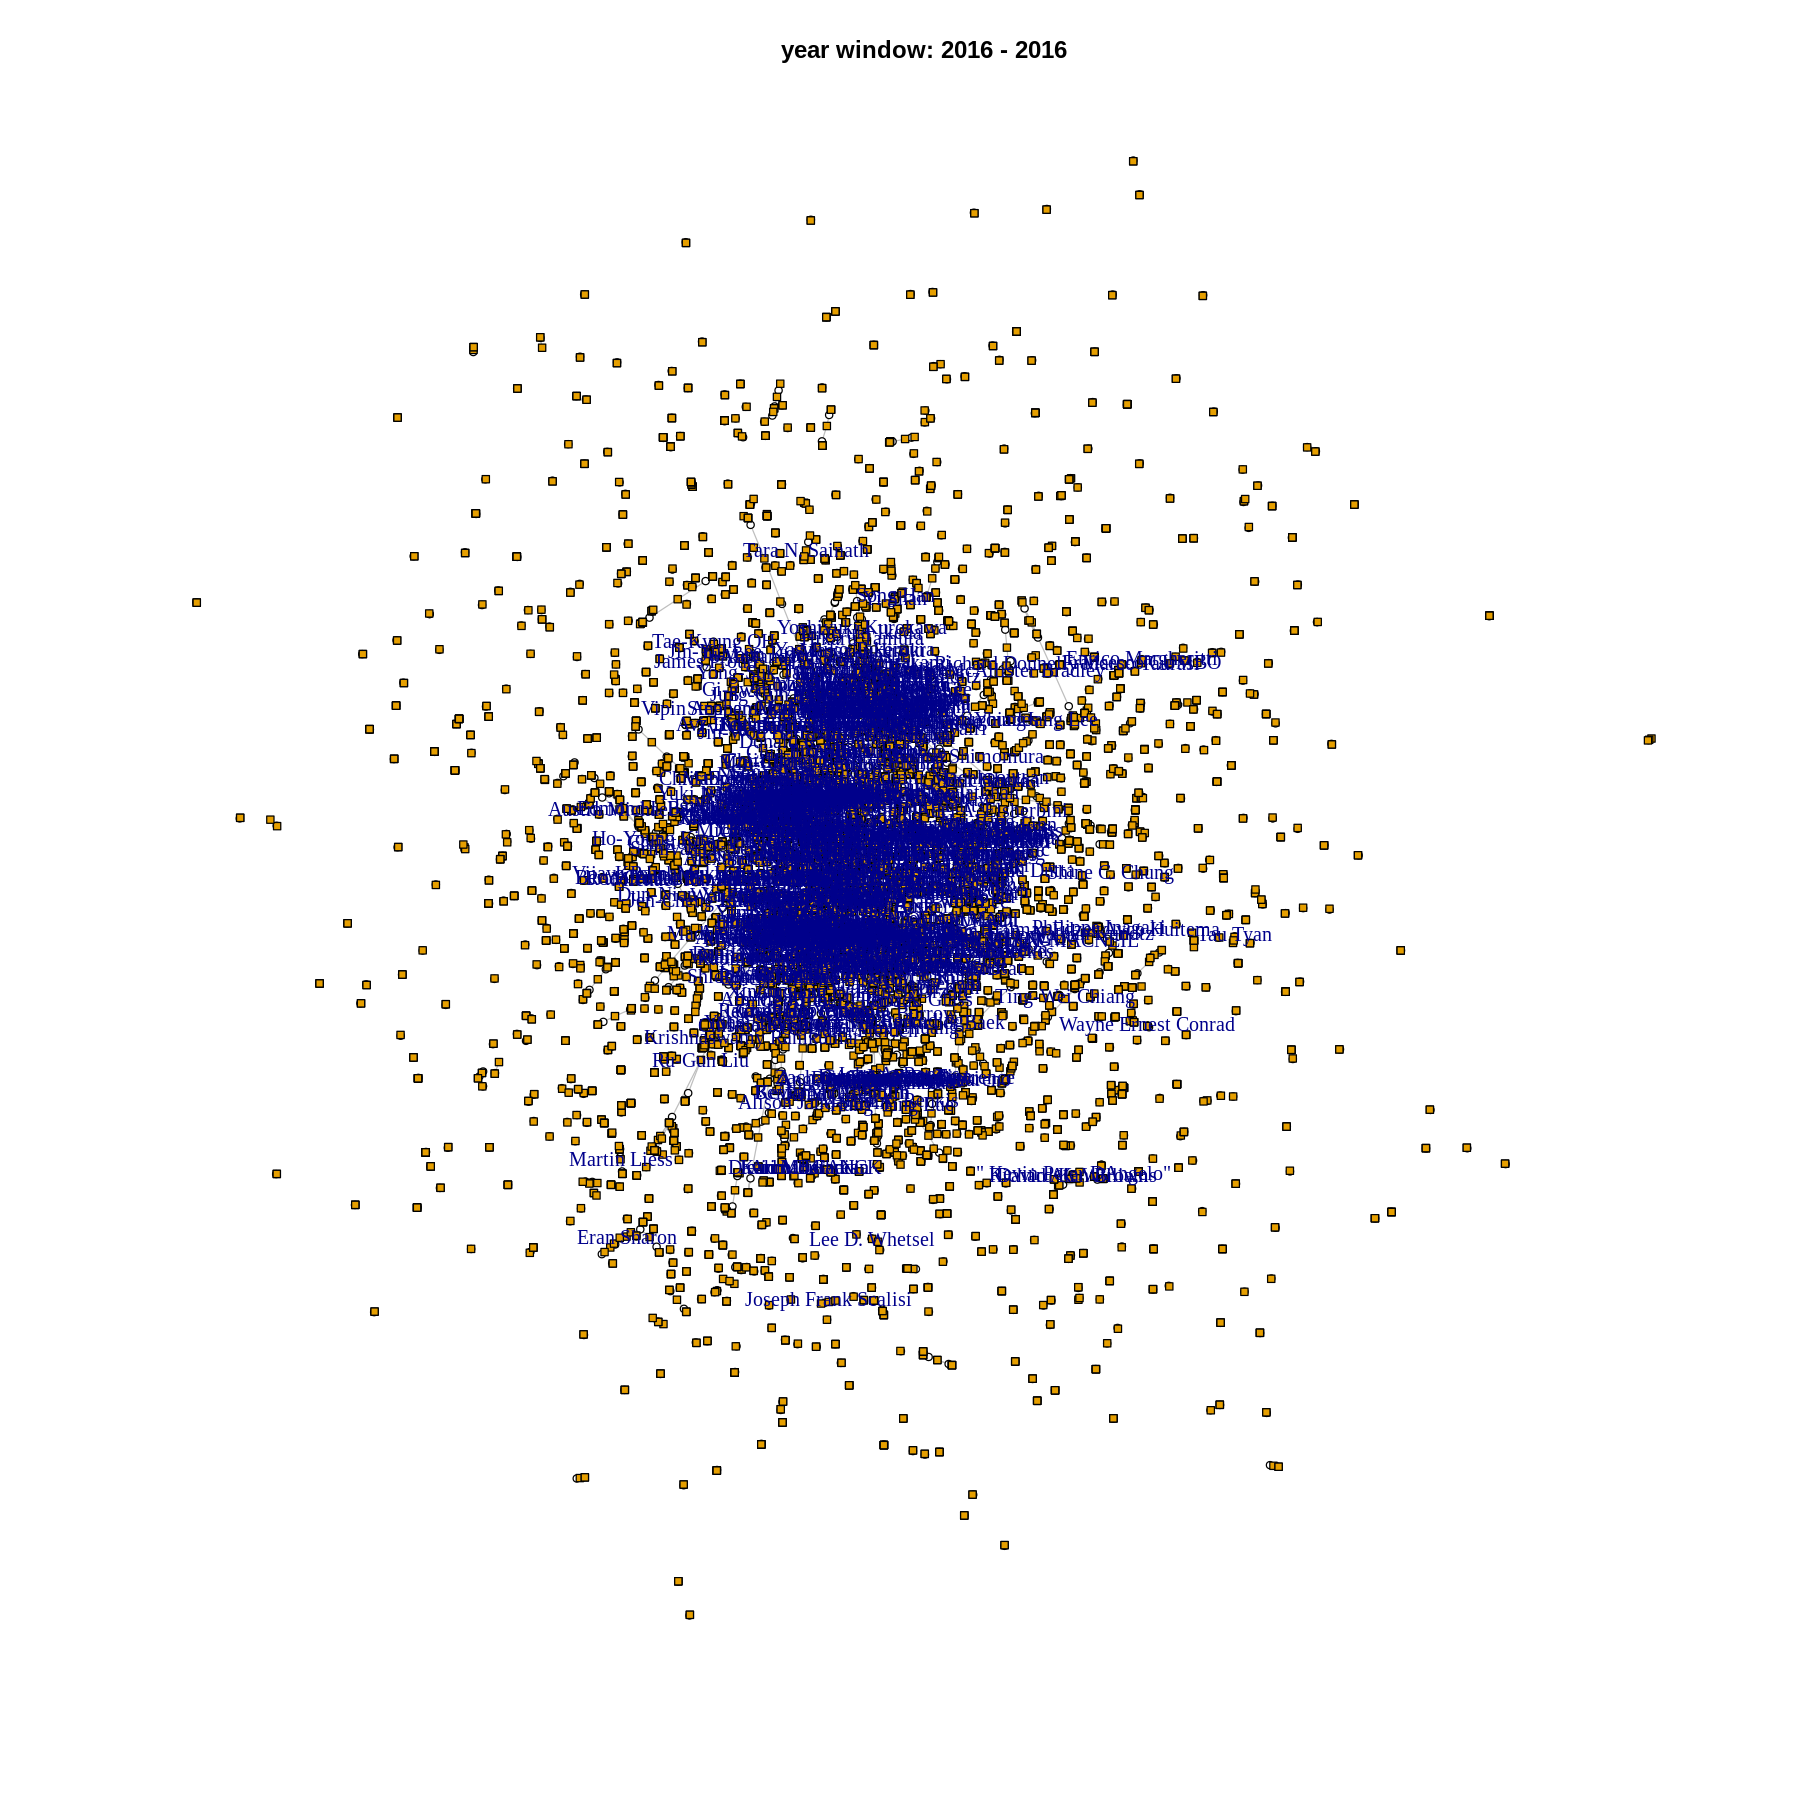

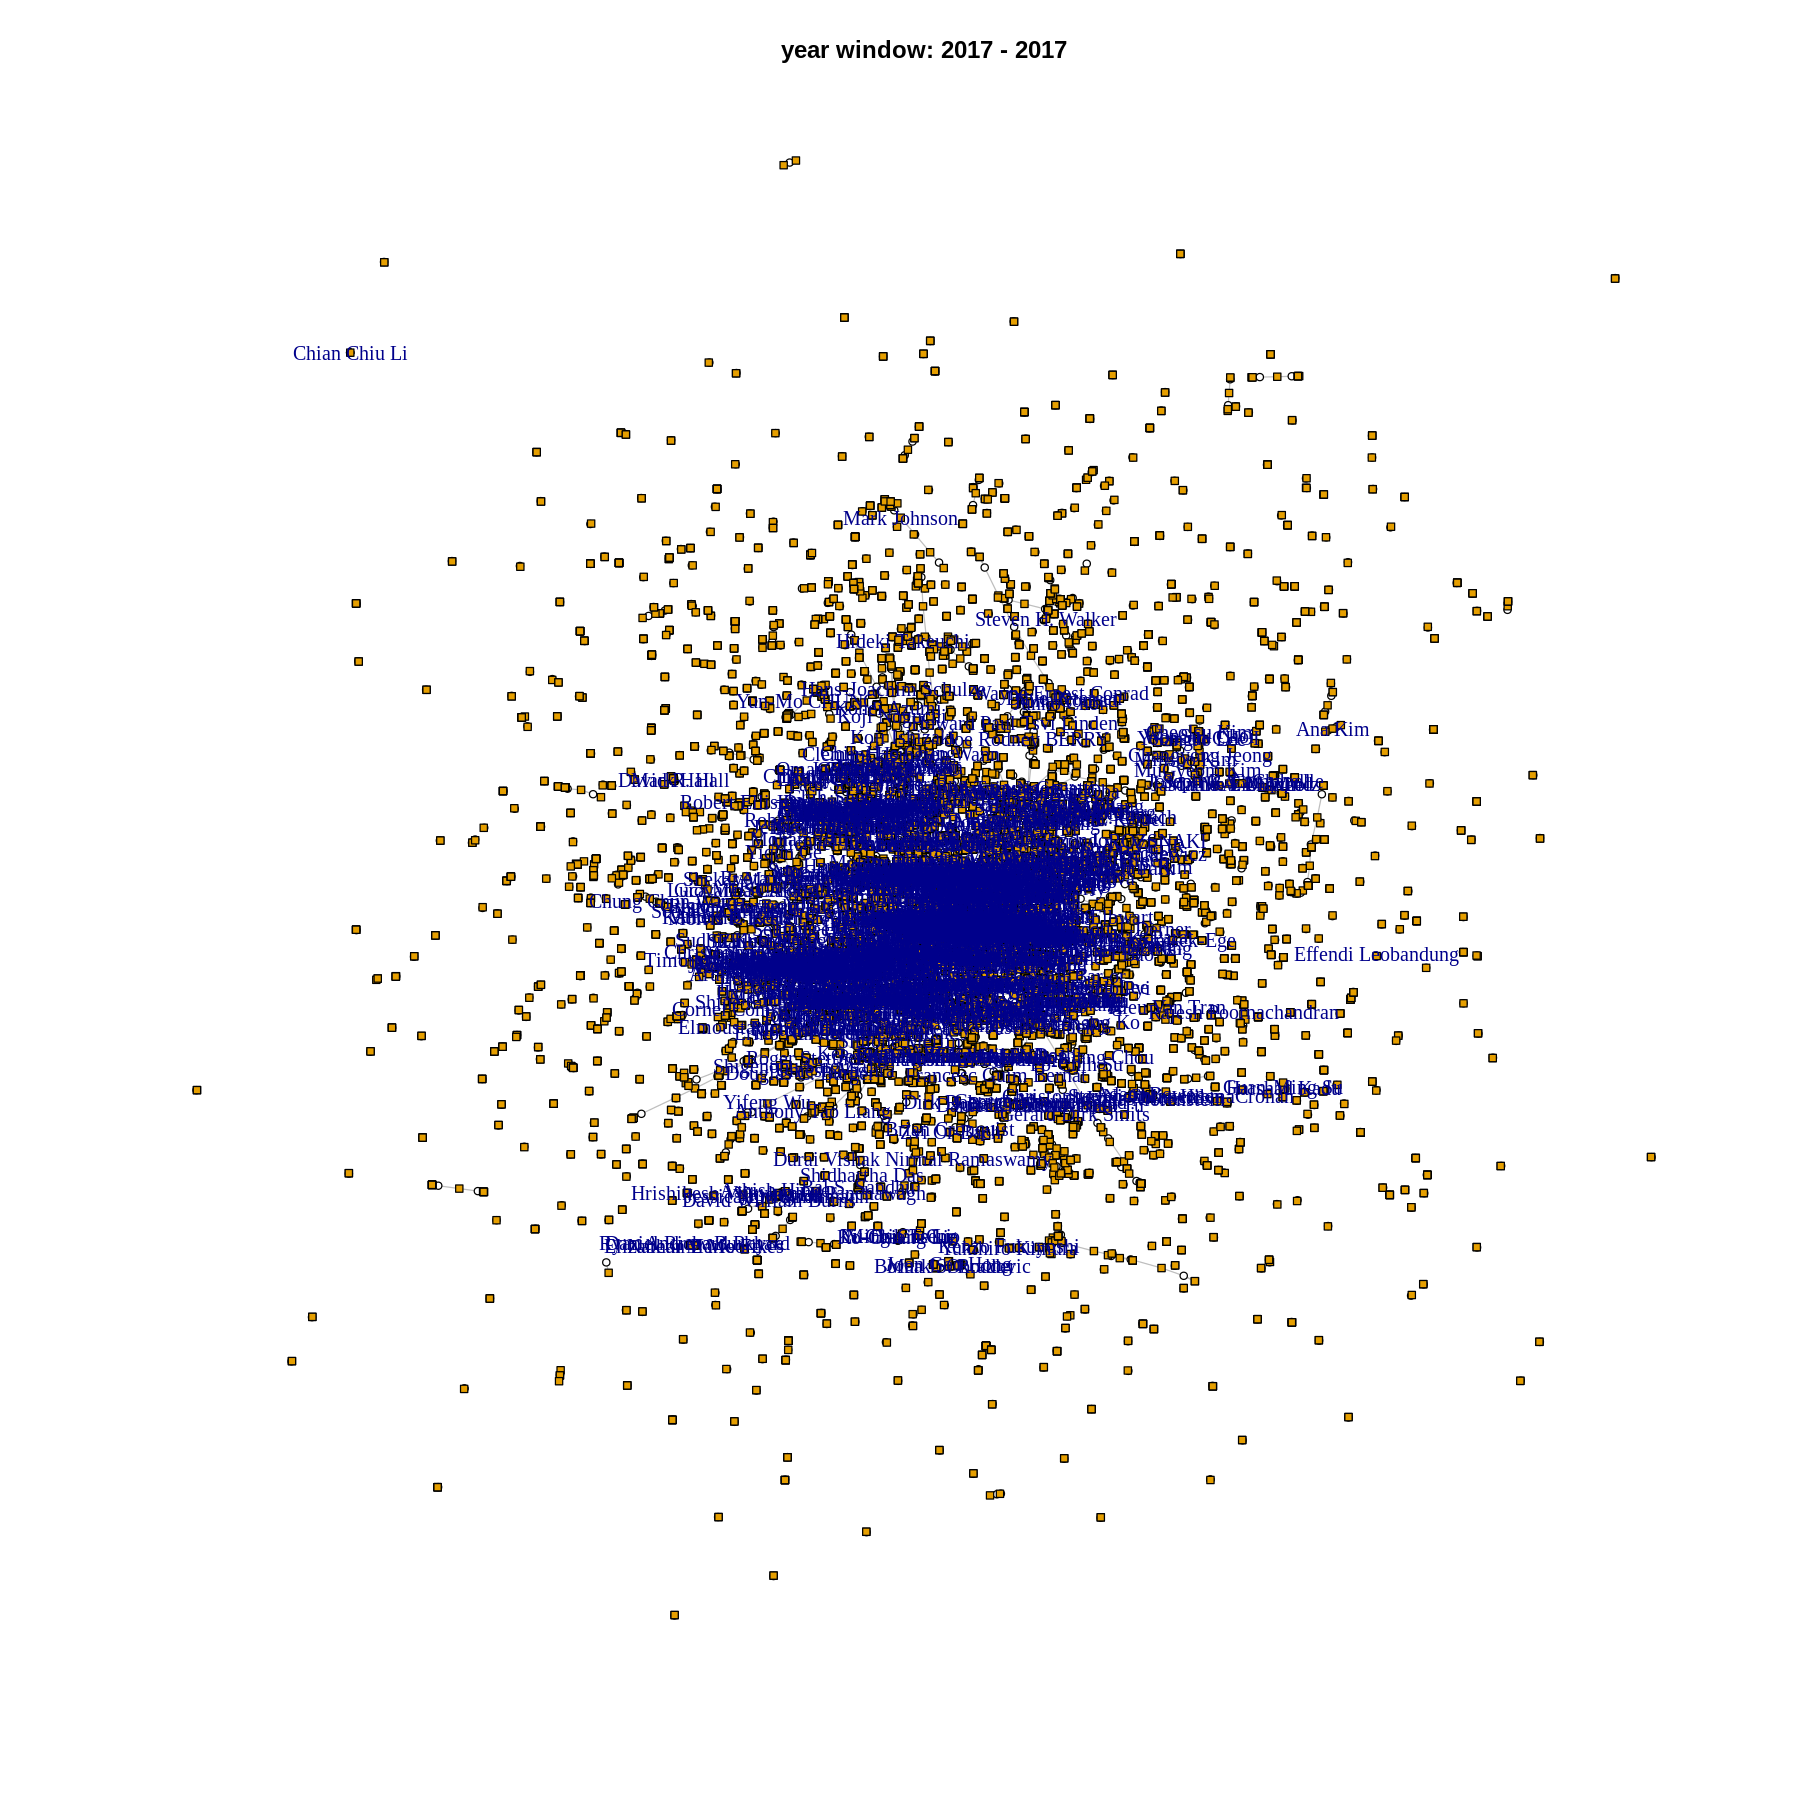

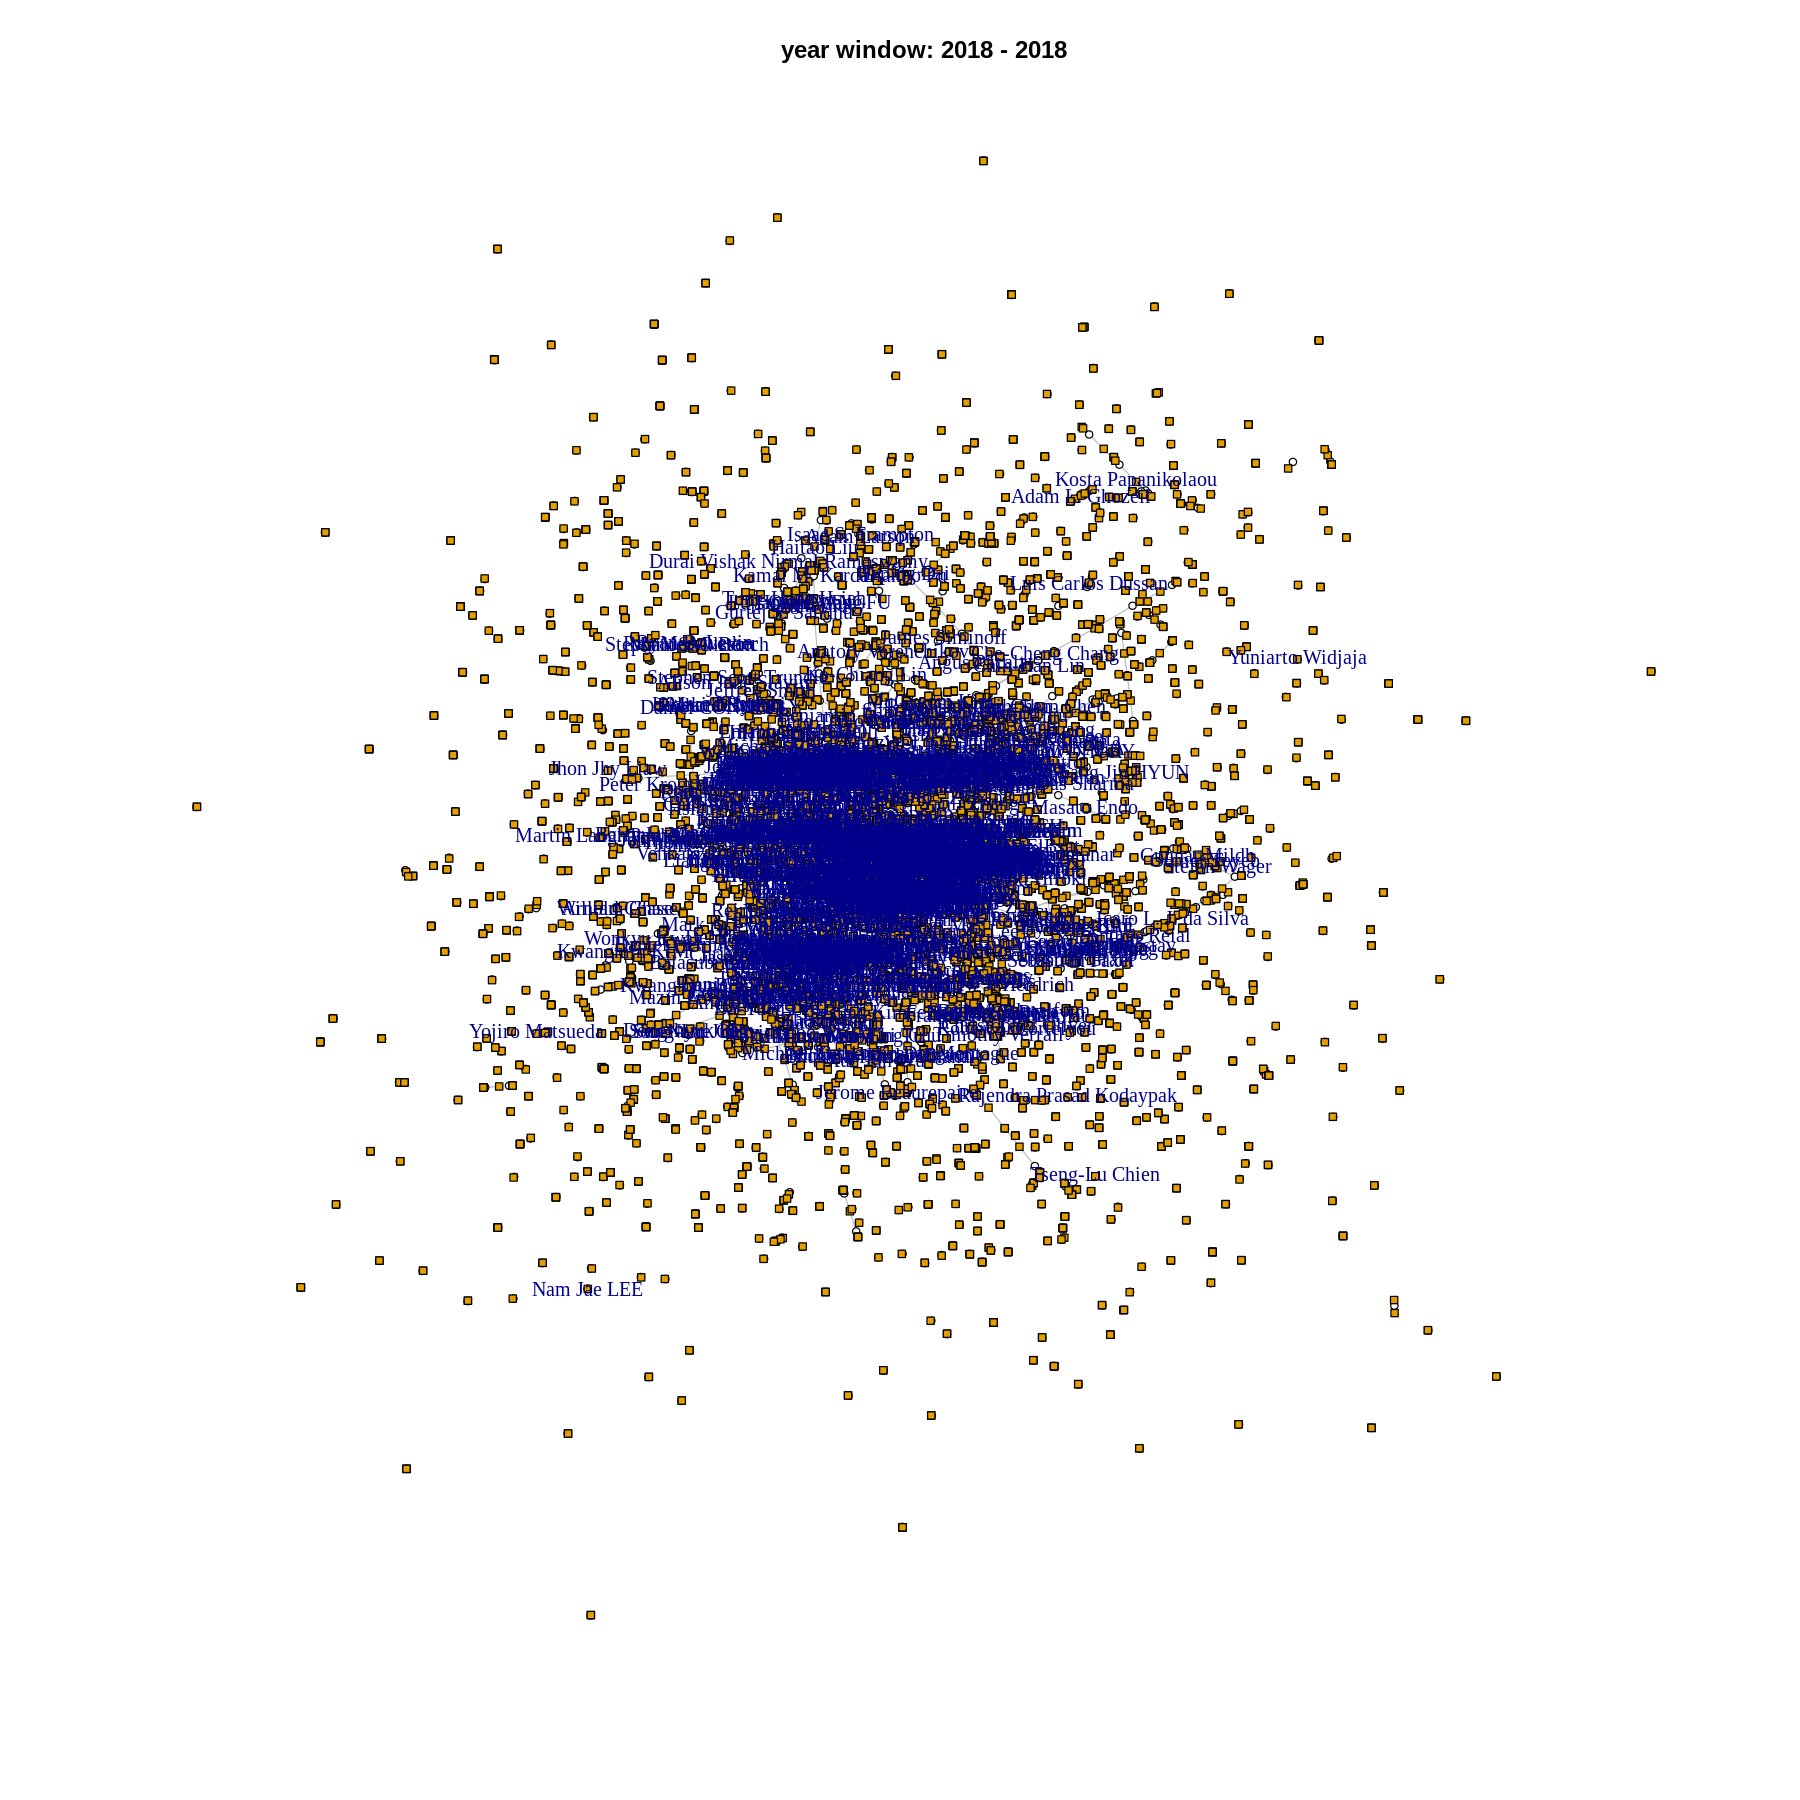

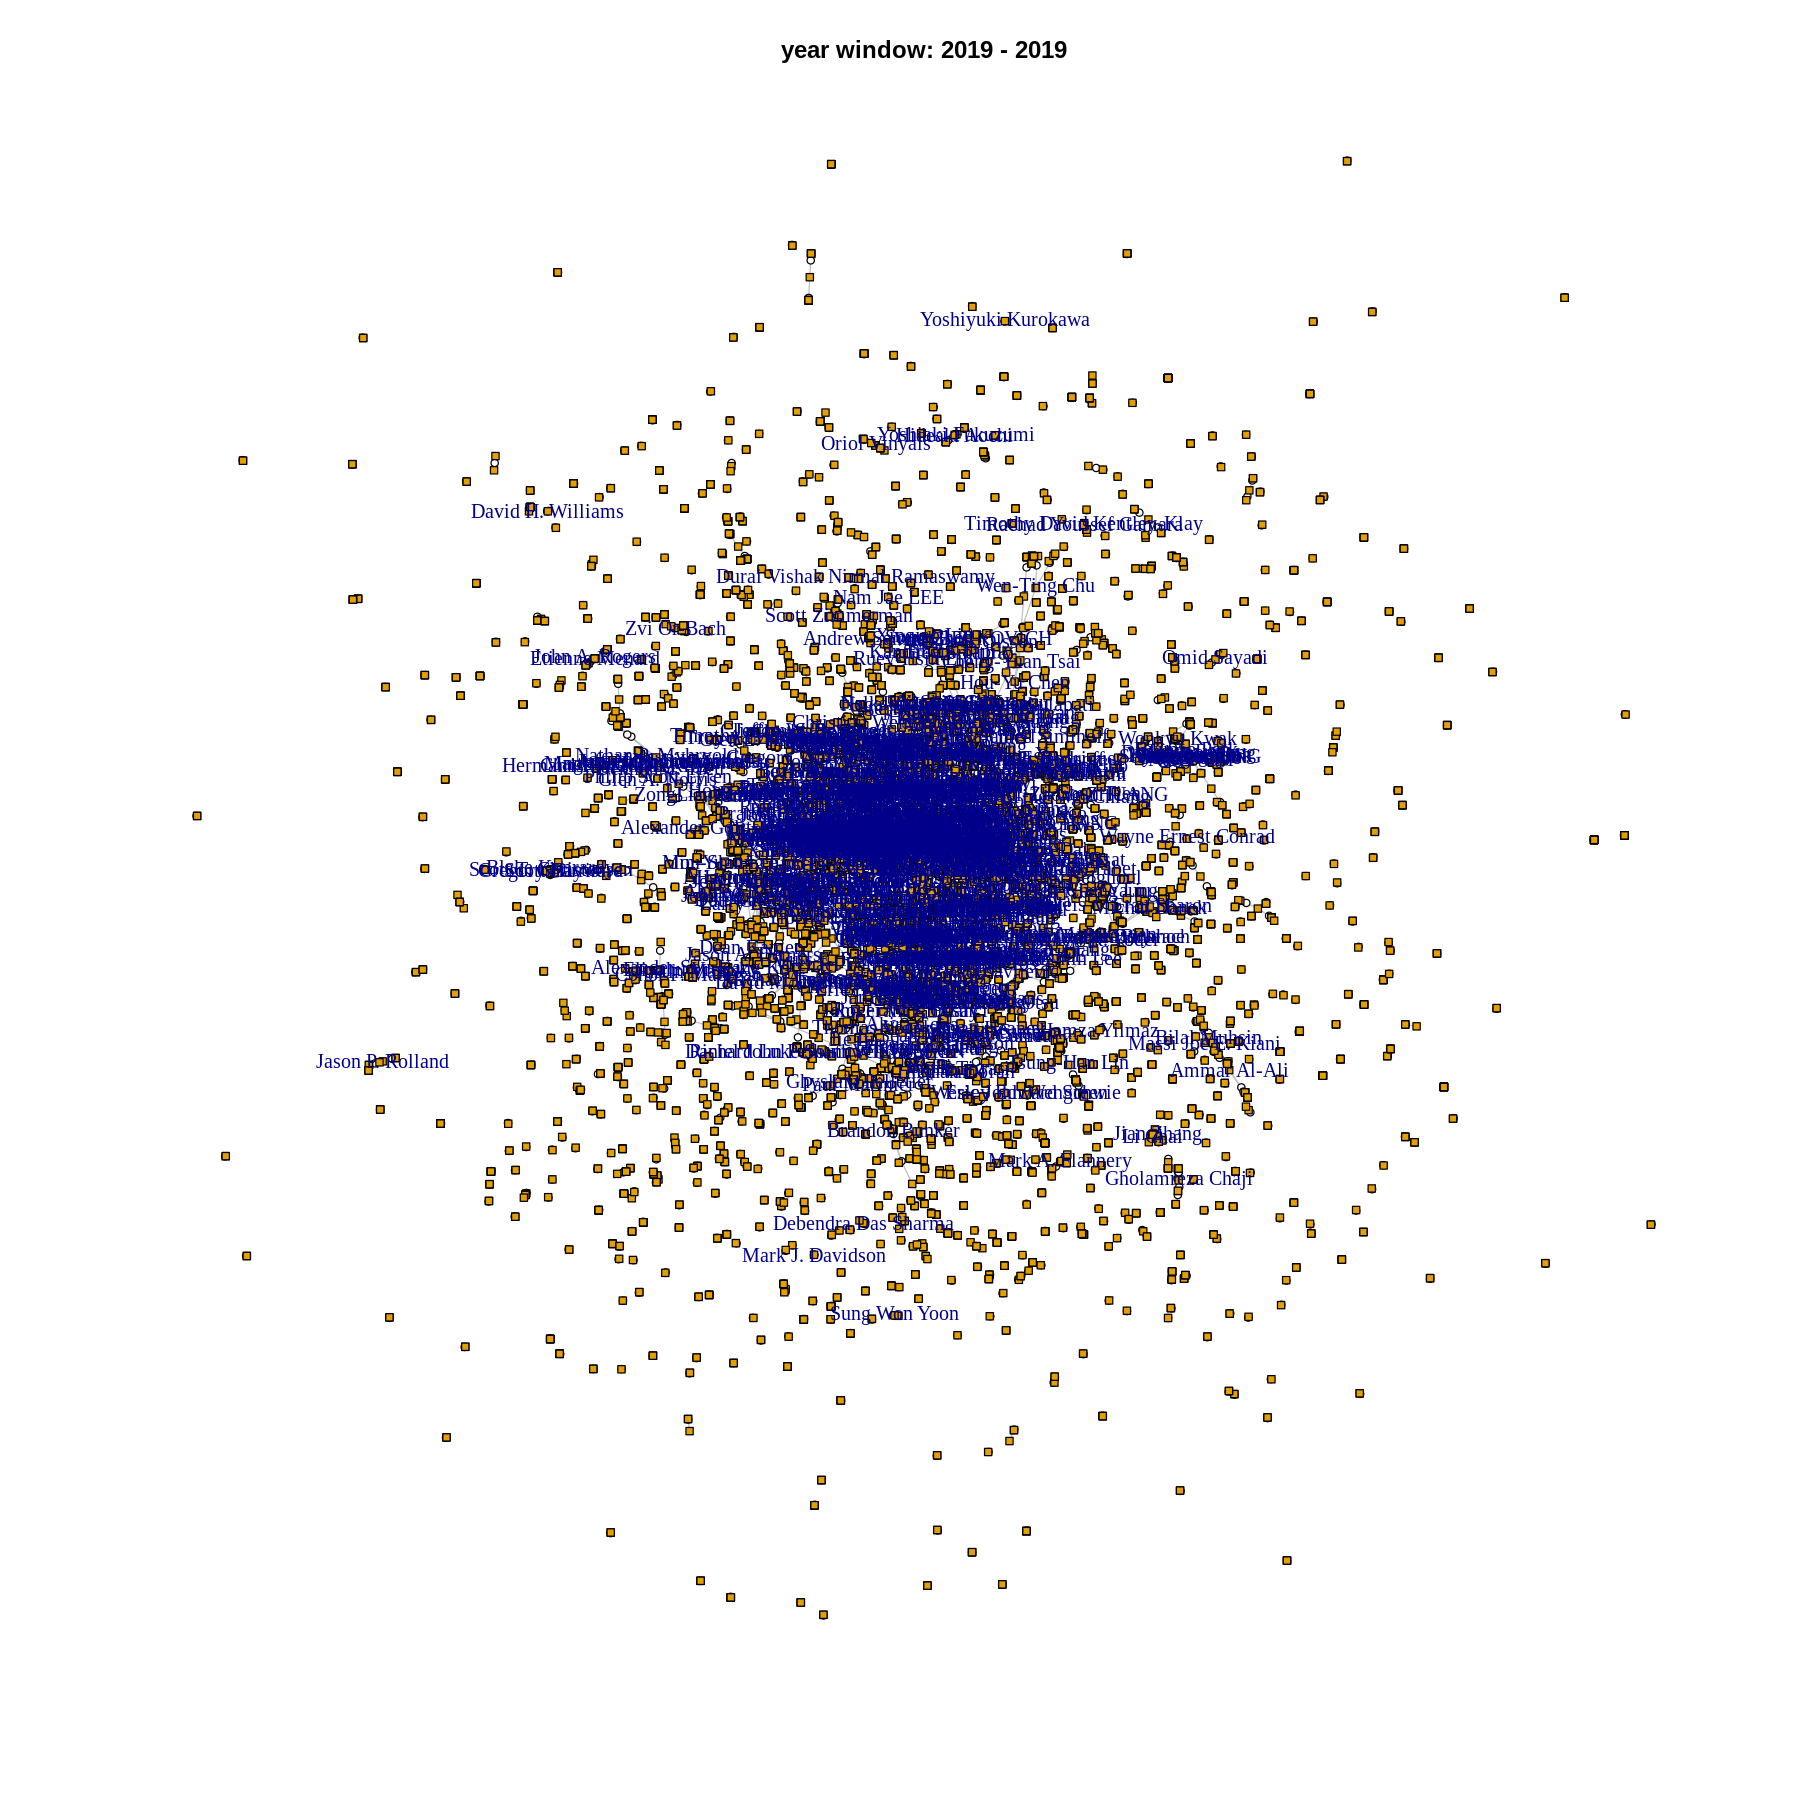

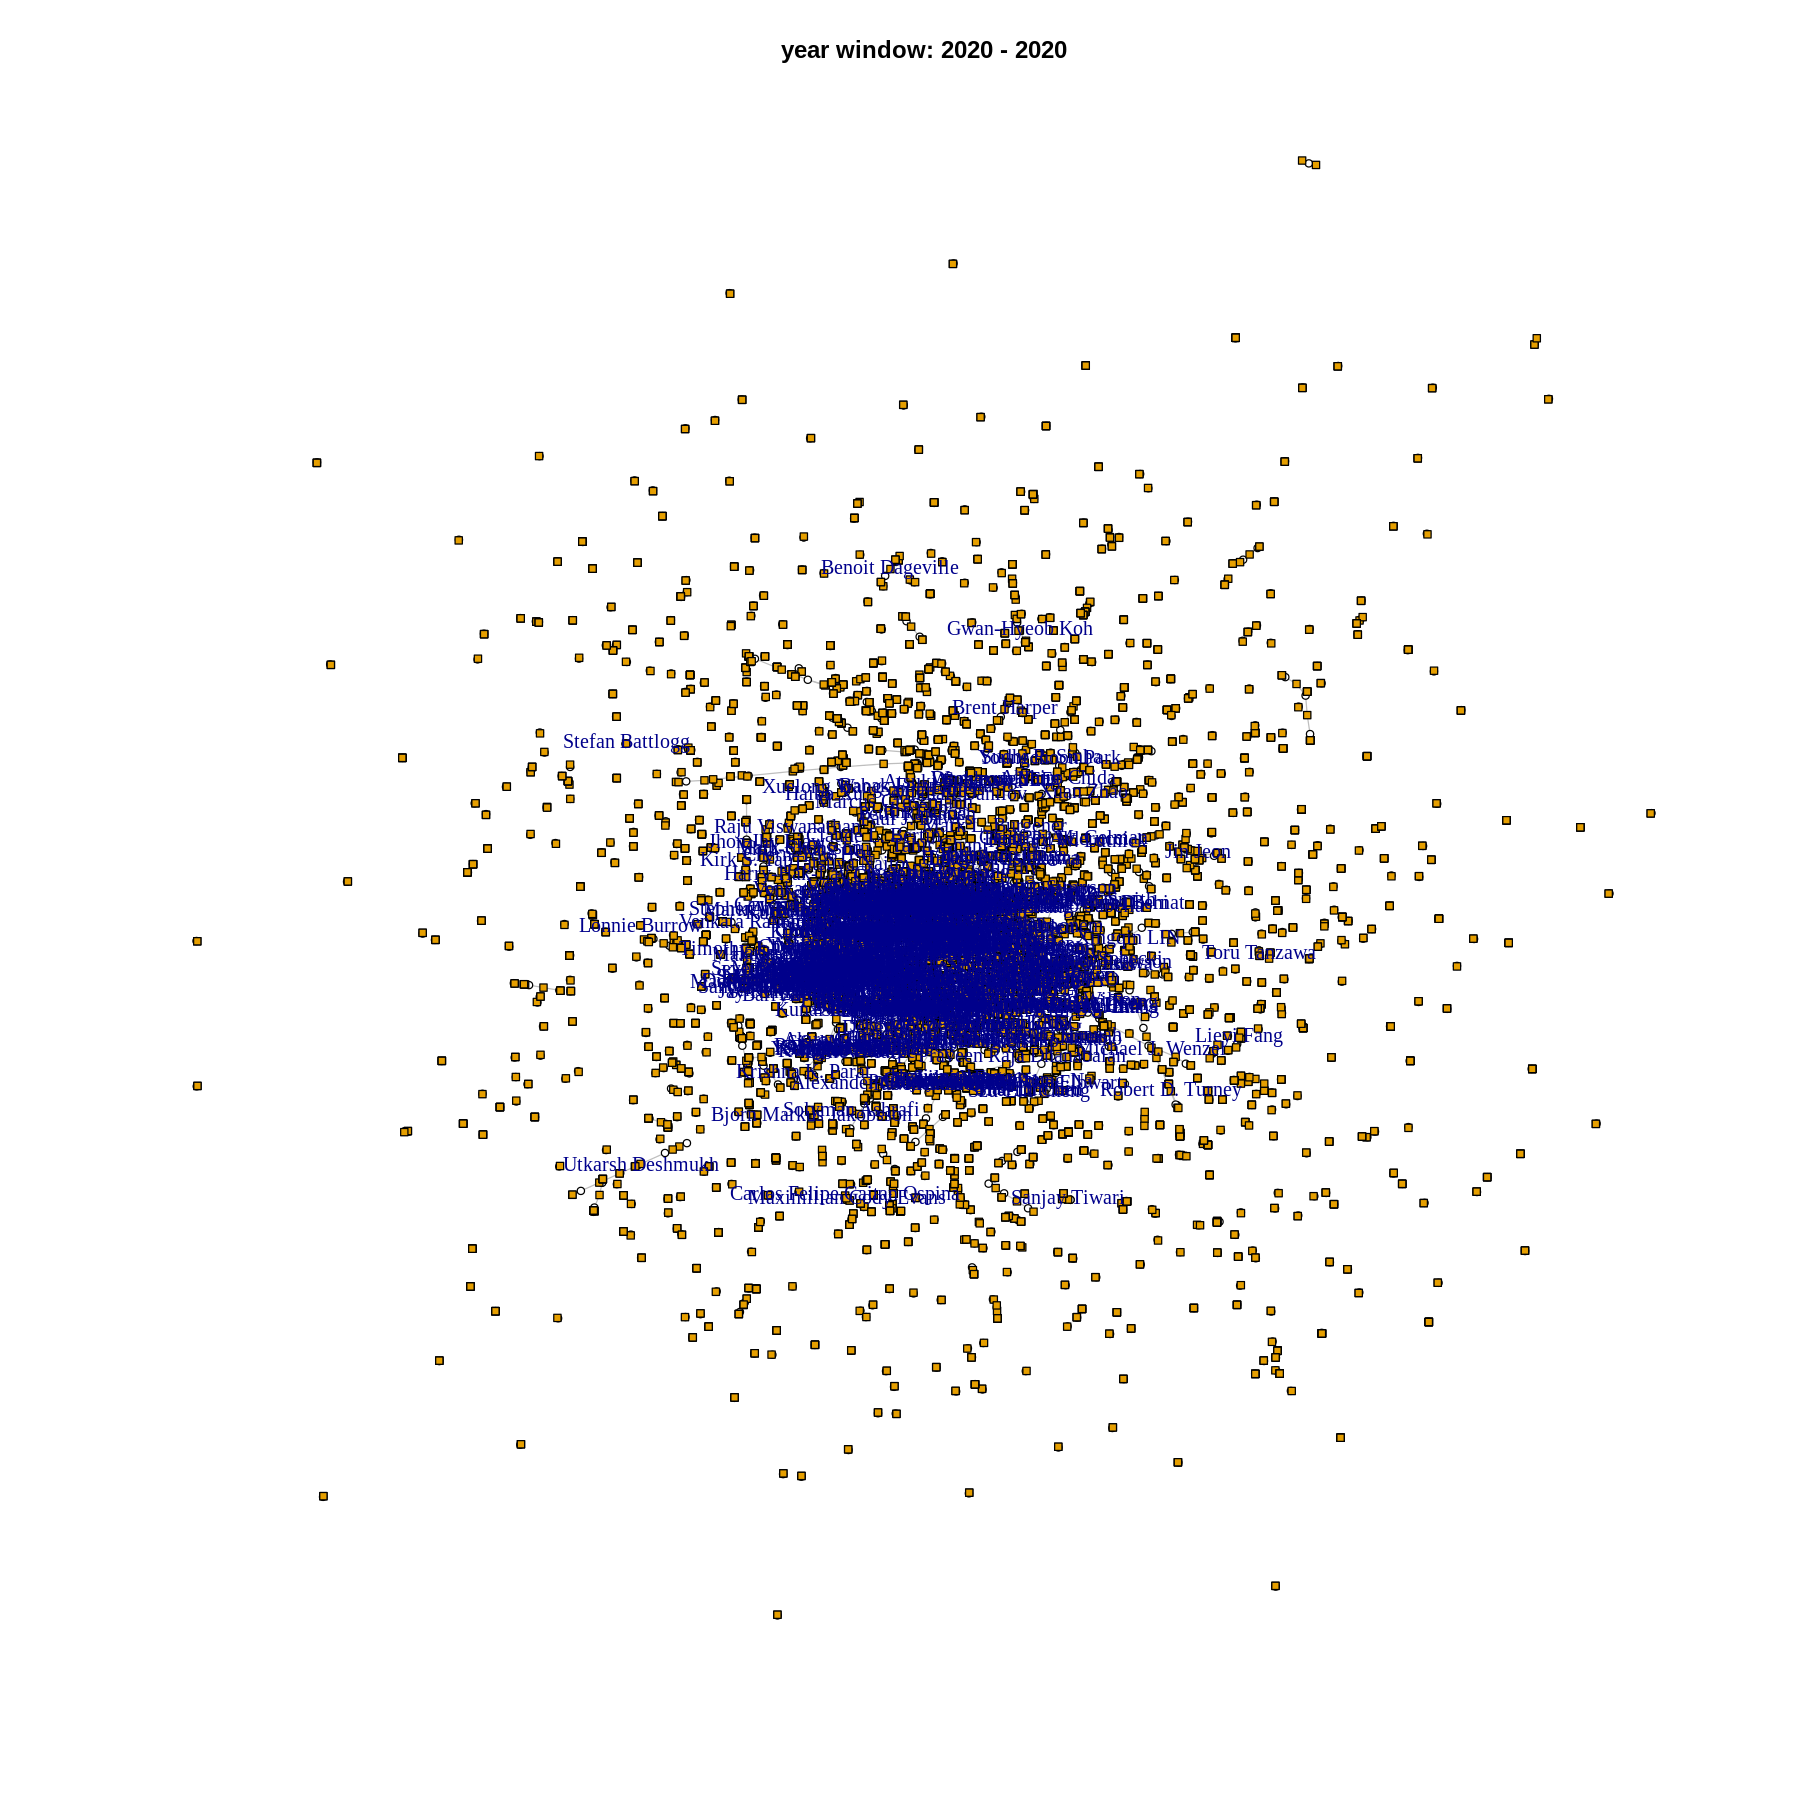

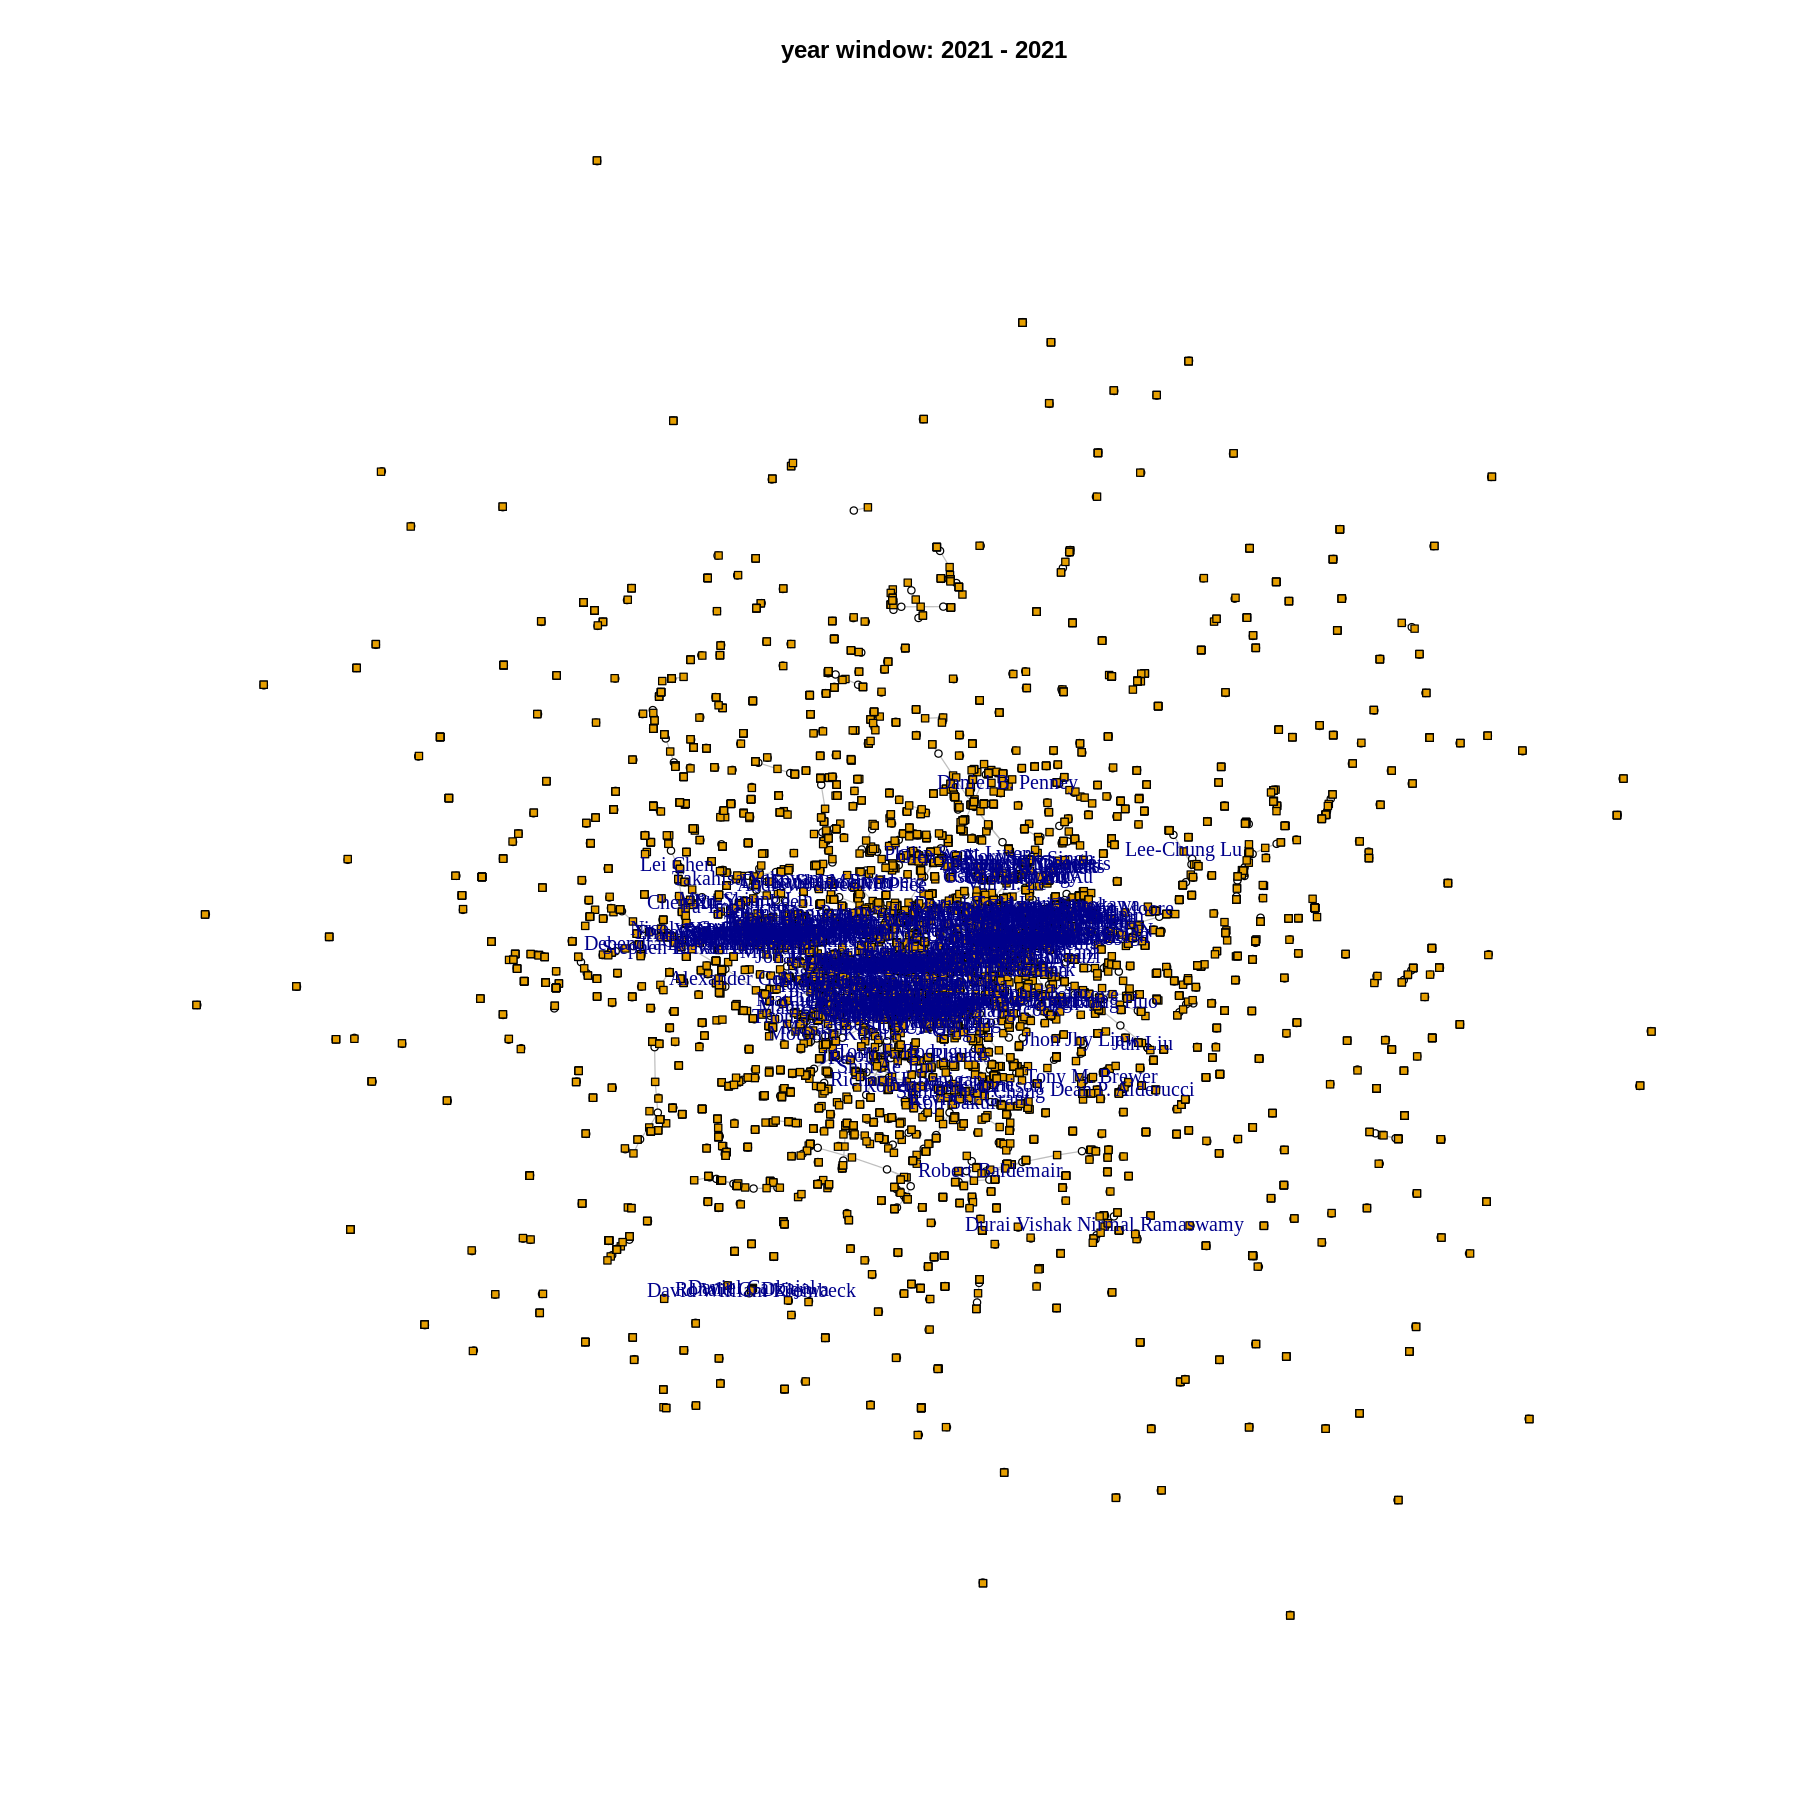

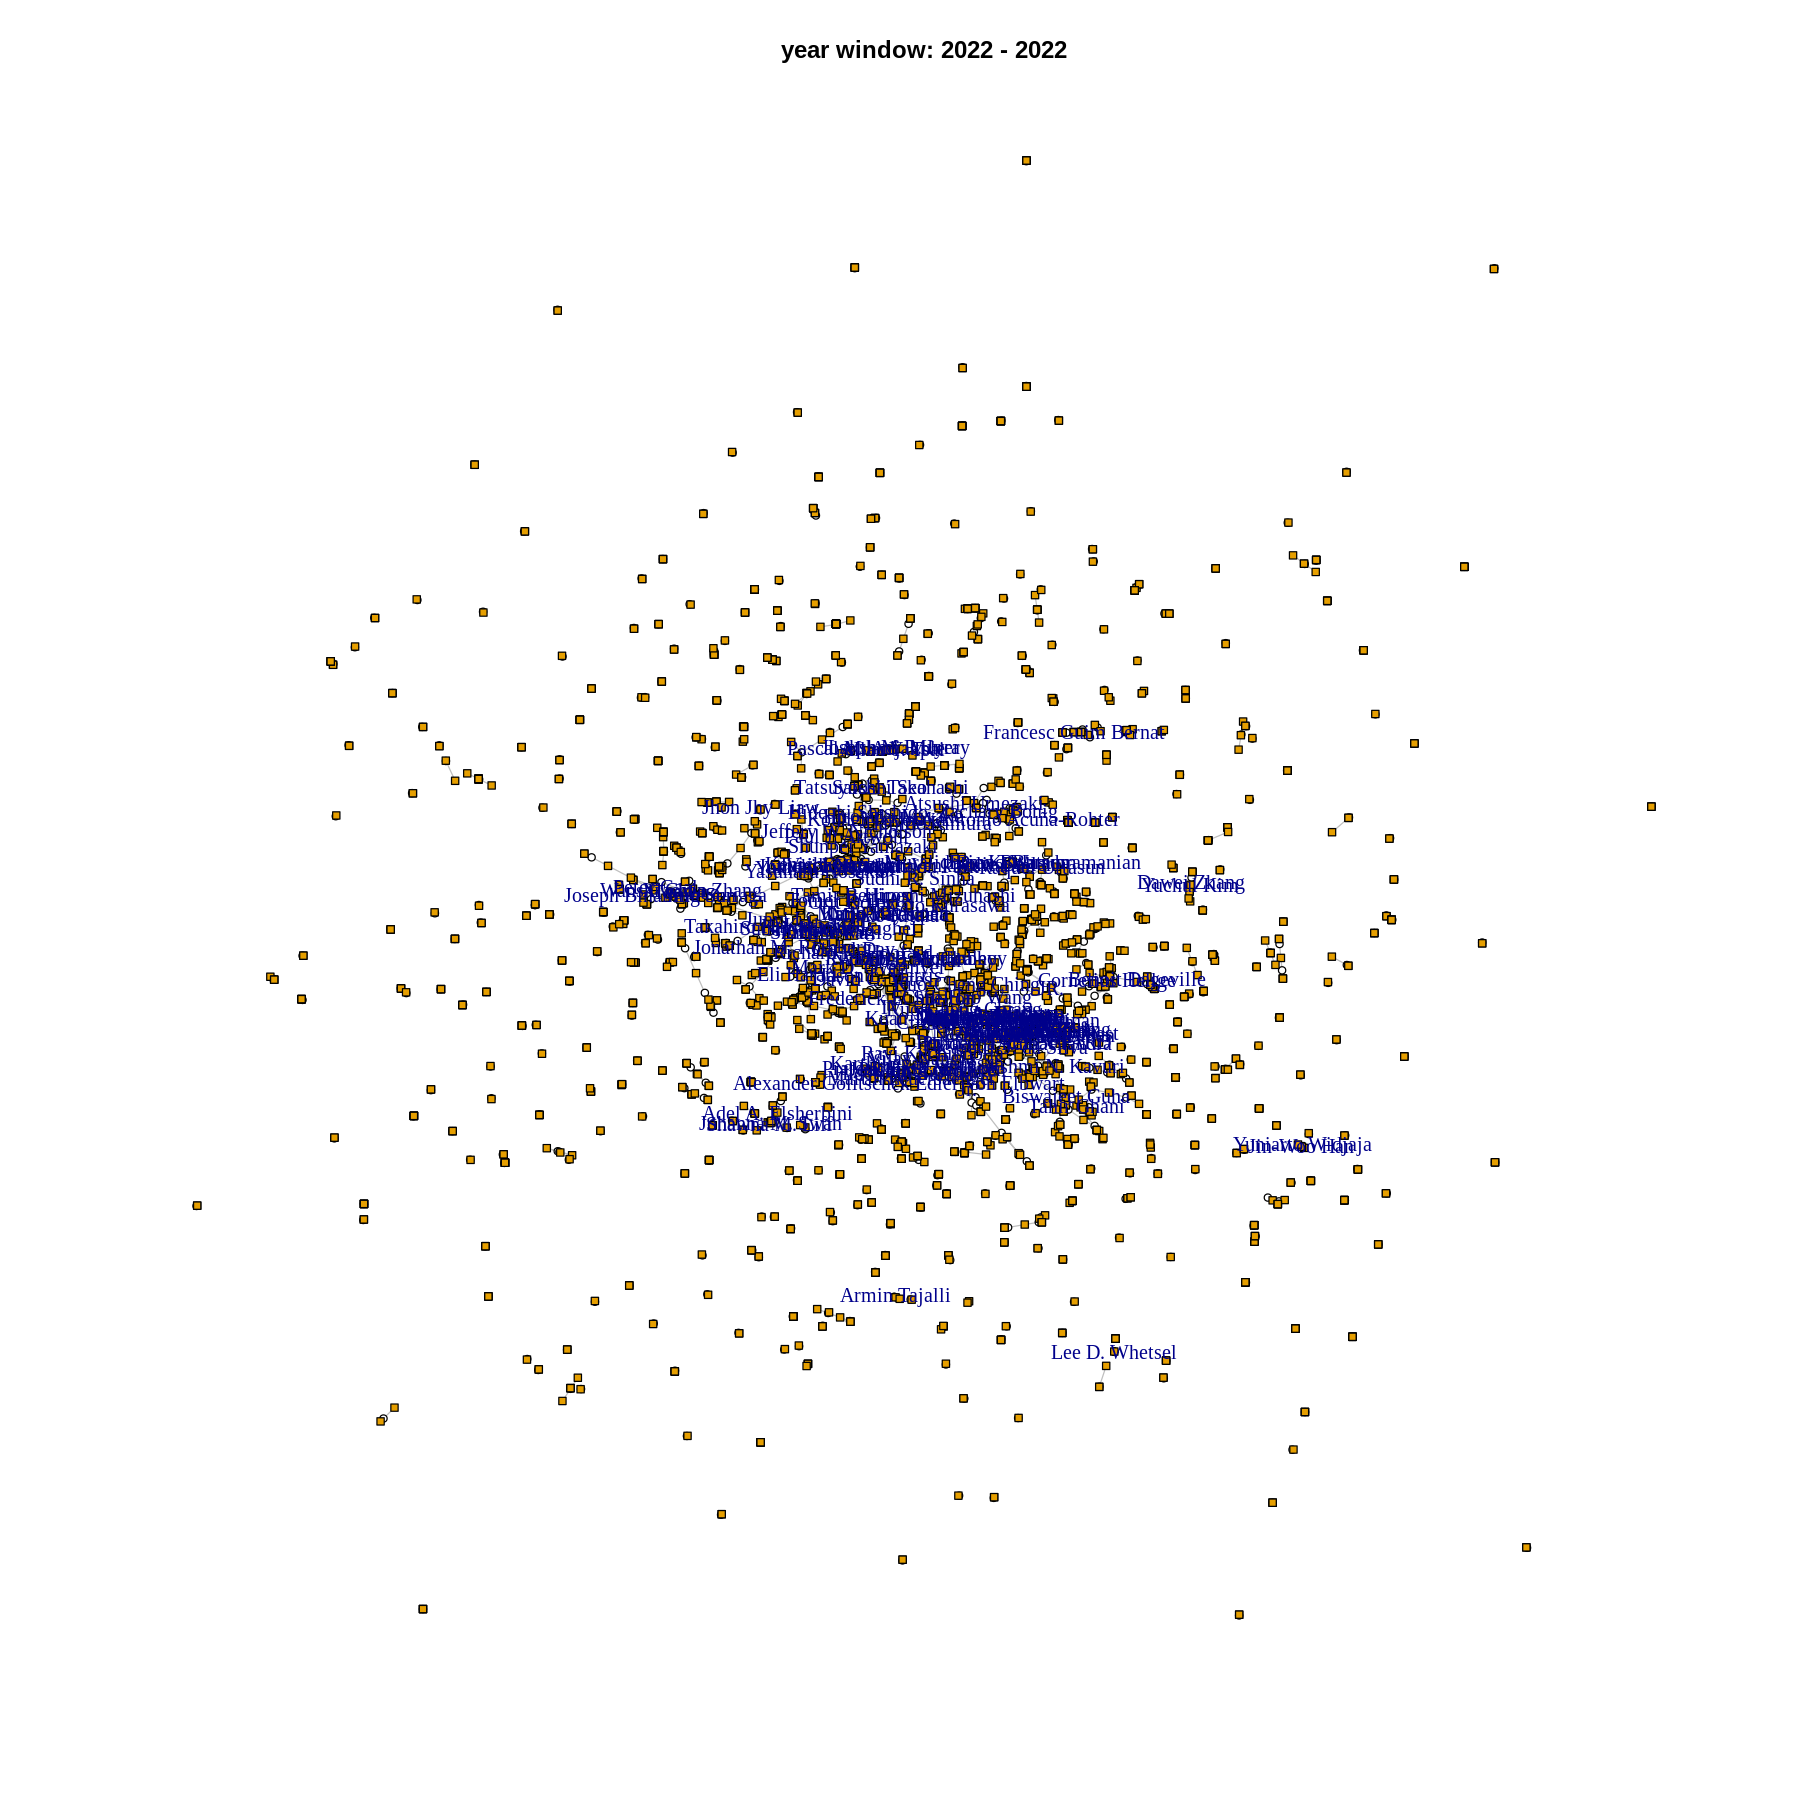

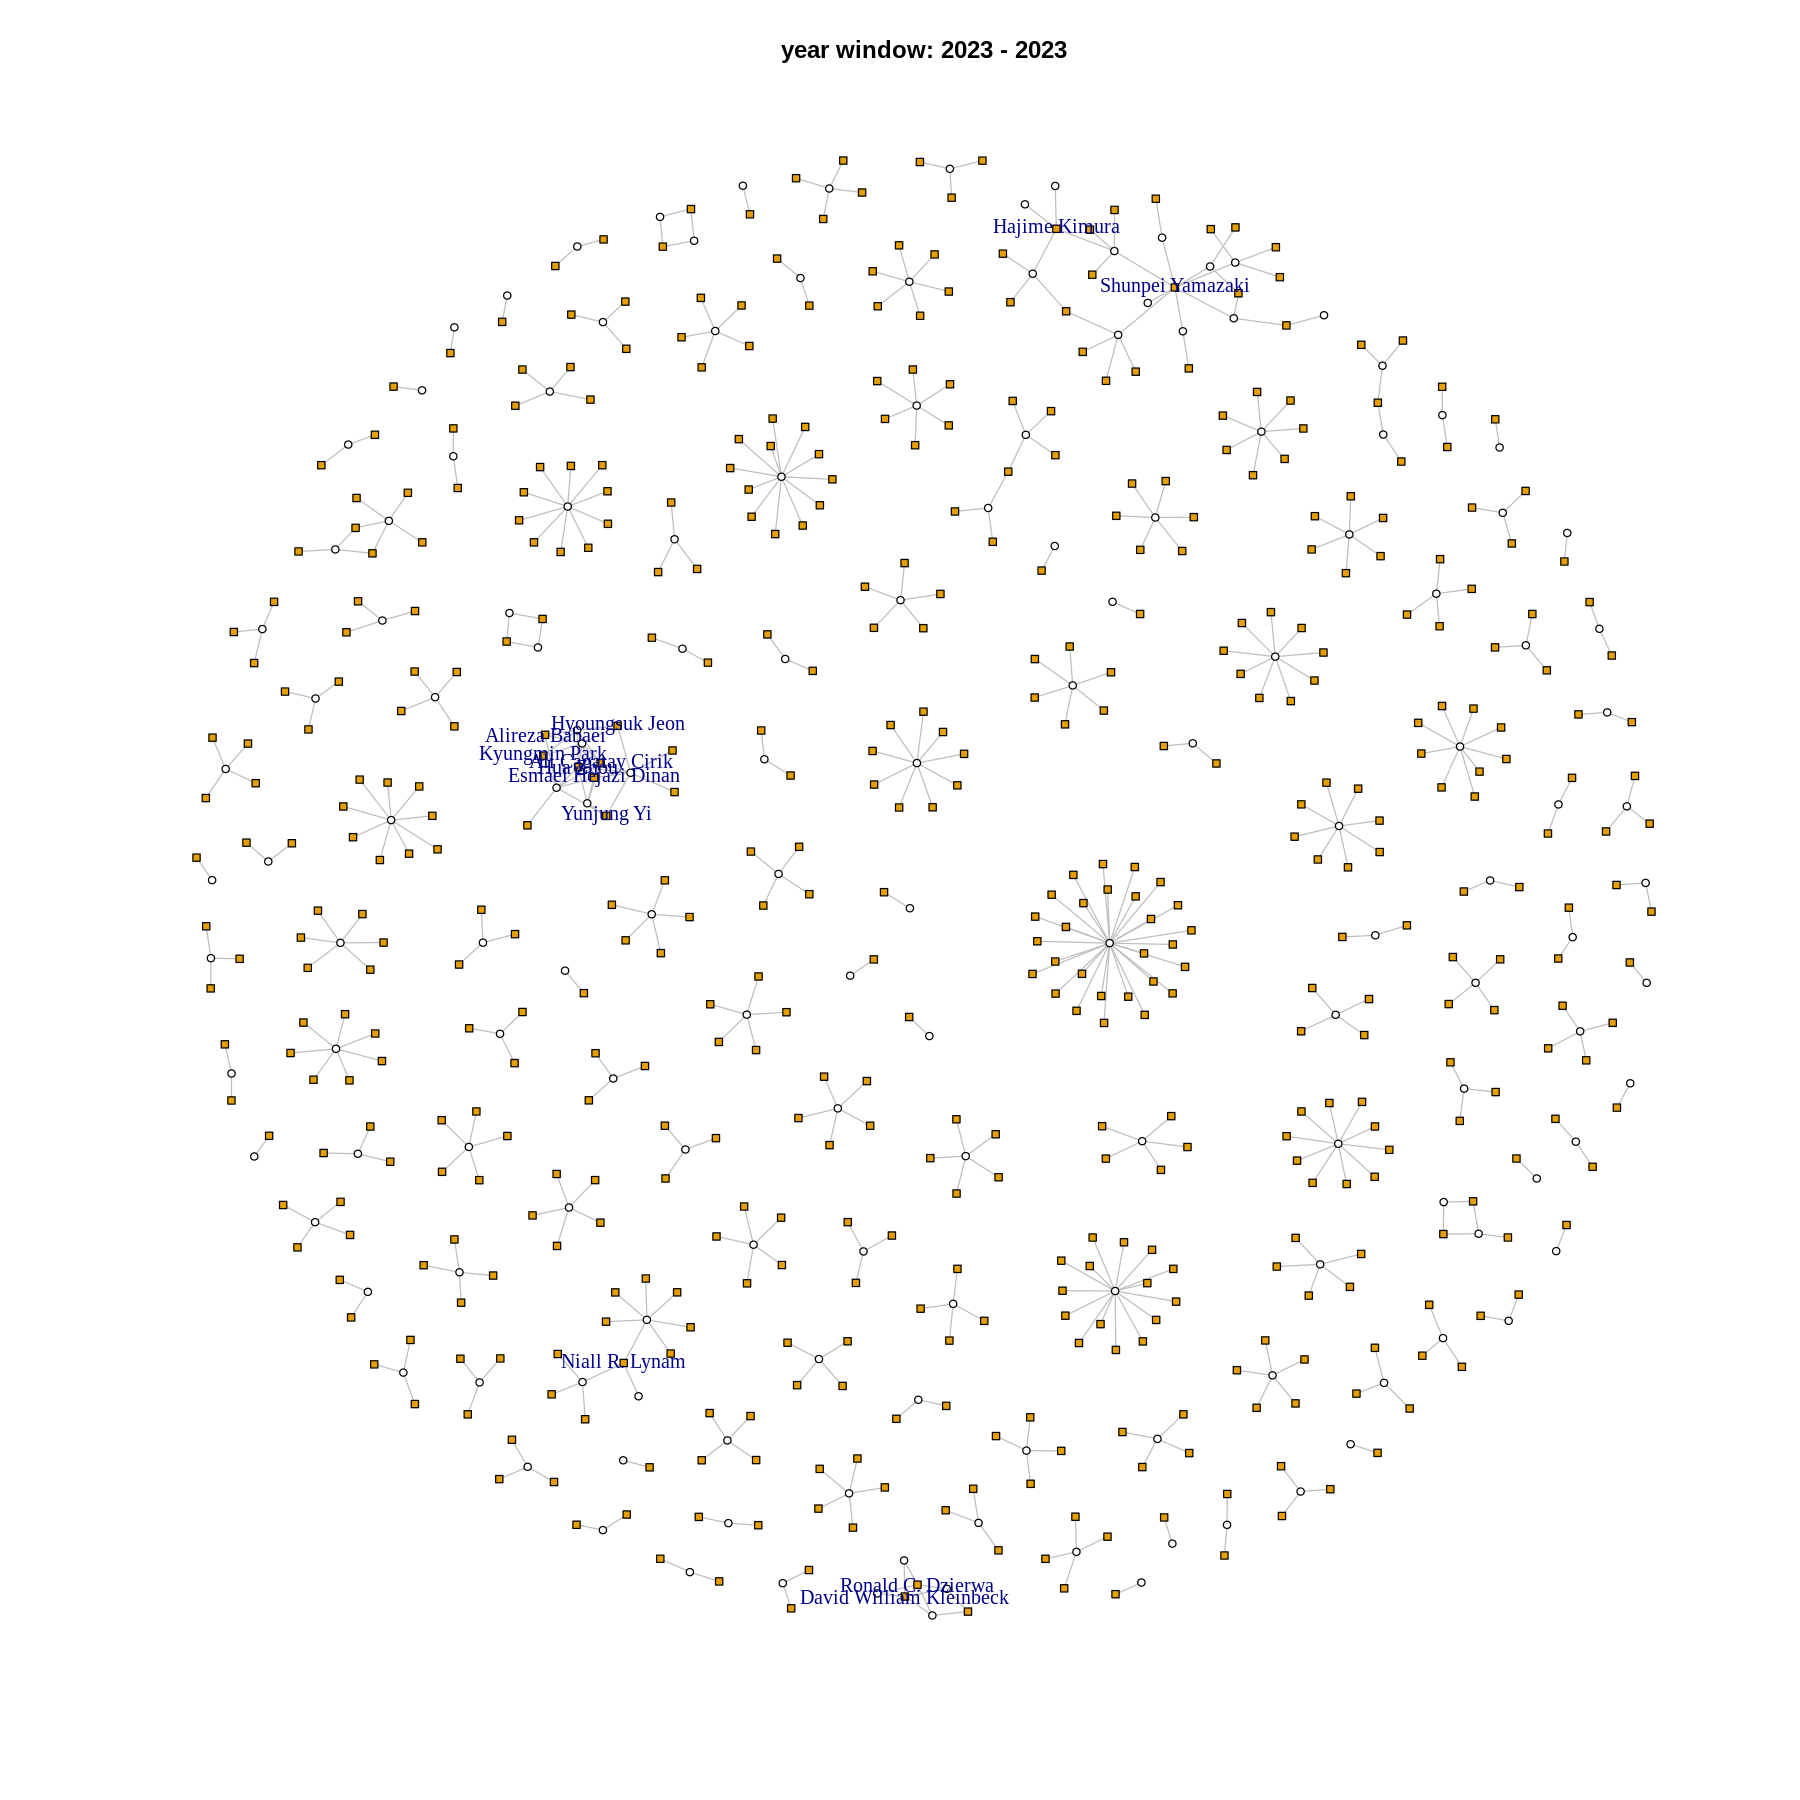

In [ ]:
window_width = 1
end = 2023 - window_width + 1
degree_threshold = 2
for (start_year in 2011:end) {
  edgelist <- window_patent_inventor_edgelist(window_width, start_year)
  graph <- bipartite_graph(edgelist)
  plotting_key_inventors(graph, degree_threshold)
}

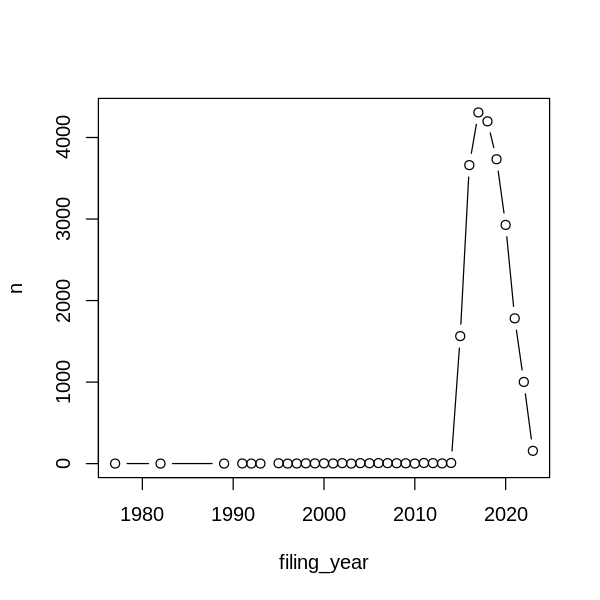

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(df %>% count(filing_year), type = "b")

In [ ]:
assignee = df %>% count(assignee)
head(assignee[order(assignee$n, decreasing = T),],10)

assignee                                         n  
4174 Semiconductor Energy Laboratory Co., Ltd.        962
3776 Qualcomm Incorporated                            922
2284 Intel Corporation                                703
4048 Samsung Display Co., Ltd.                        657
4059 Samsung Electronics Co., Ltd.                    606
4621 Taiwan Semiconductor Manufacturing Company, Ltd. 473
2320 International Business Machines Corporation      452
3043 Micron Technology, Inc.                          373
4088 Sandisk Technologies Llc                         348
354  Apple Inc.                                       345

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


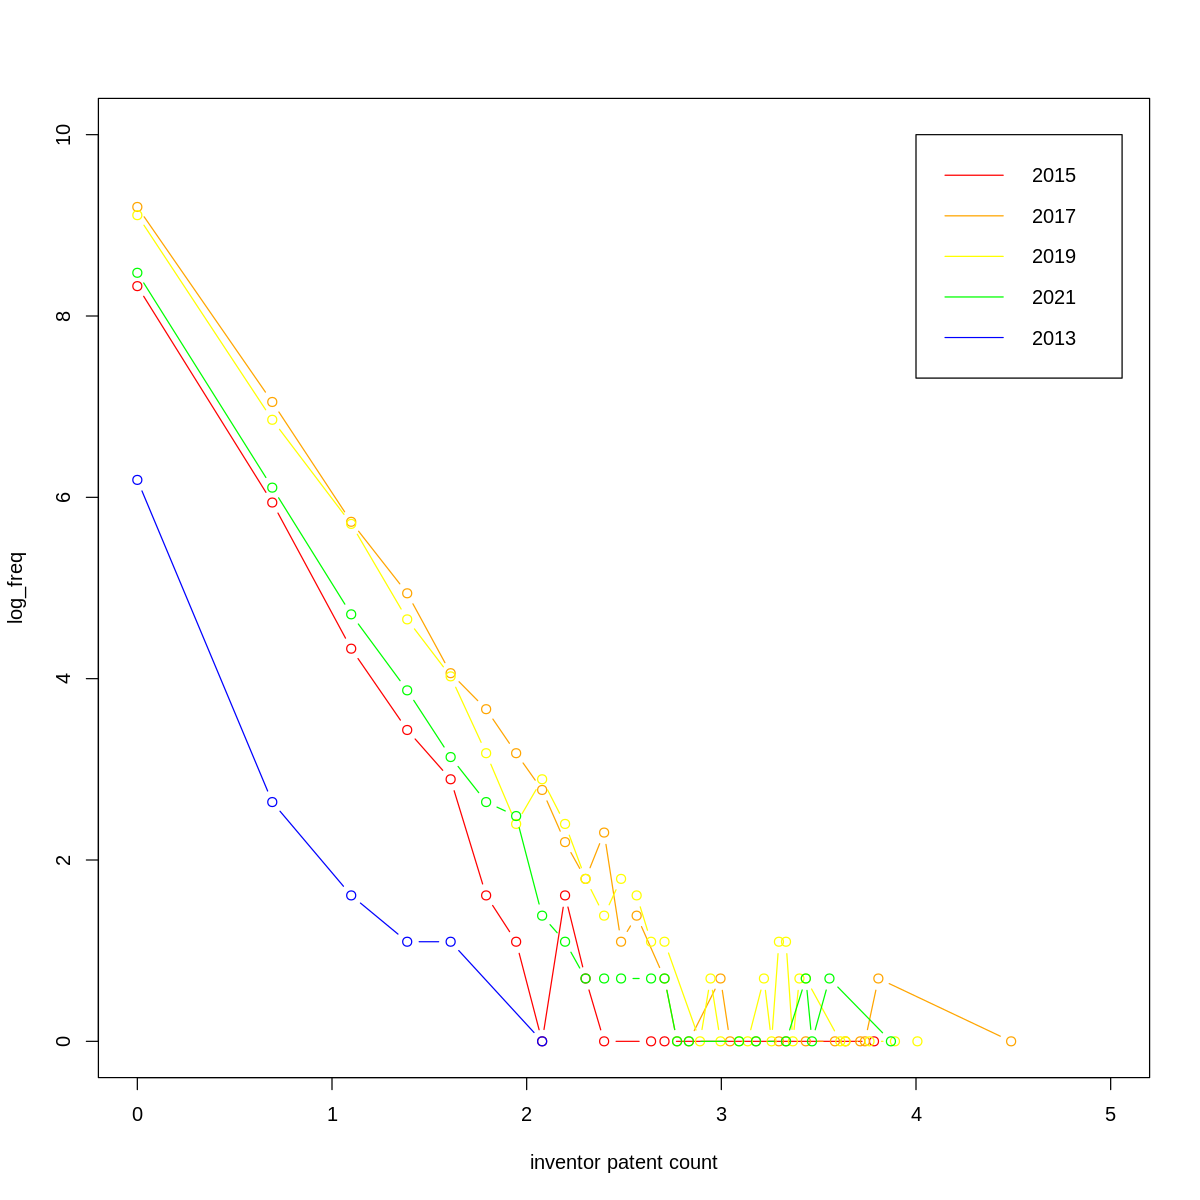

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

inventor_rank <- window_patent_inventor_edgelist(1, 2015) %>% count(inventor)
plot(log(inventor_rank %>% count(n)),
 type="b", ylab="log_freq", xlab = "inventor patent count",
 xlim=c(0,5), ylim = c(0,10), col = "red")

lines(log(window_patent_inventor_edgelist(1,2017) %>% count(inventor) %>% count(n)),type="b", col = "orange")
lines(log(window_patent_inventor_edgelist(1,2019) %>% count(inventor) %>% count(n)),type="b",col = "yellow")
lines(log(window_patent_inventor_edgelist(1,2021) %>% count(inventor) %>% count(n)),type="b",col = "green")
lines(log(window_patent_inventor_edgelist(1,2023) %>% count(inventor) %>% count(n)),type="b",col = "blue")
legend(4,10, legend=c("2015", "2017","2019","2021","2013"),col=c("red","orange","yellow","green","blue"), lty = 1)